# Further line analysis from saved moment images

The previous notebook has grown too long, so I am starting a new one.  What I plan to do here is:

1. [X] [Cl III] density ratio. *Conclusion:* [Cl III] is useless
2. [X] [S II] density - this is the best
3. [X] He II analysis – ionizing luminosity and density
    *This has a mistake at the moment, which I need to track down* Now fixed in Org file
4. [X] [Ar IV] and [Ar III] ionization balance
2. [ ] Maybe tetrablok binning and make figure
3. [X] Profile cuts across the bow shock
4. [ ] Analysis of average line velocities


In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Image
import regions
import pandas as pd
import cmasher as cmr
import pyneb as pn

sns.set_context("talk")
sns.set_color_codes()

In [2]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Image
import regions
import sys
import pandas as pd
import cmasher as cmr
import pyneb as pn

sns.set_context("talk")
sns.set_color_codes()

In [3]:
def trim_edges(im, m):
    """Trim m pixels of each edge of image in place by setting mask"""
    im.mask[:m, :] = True
    im.mask[-m:, :] = True
    im.mask[:, :m] = True
    im.mask[:, -m:] = True
    return None

In [4]:
datadir = Path.cwd().parent.parent / "data"
figdir = Path.cwd().parent.parent / "figs"

In [5]:
im6716 = Image(str(datadir / "ngc346-sii-6716-bin01-sum.fits"))
im6731 = Image(str(datadir / "ngc346-sii-6731-bin01-sum.fits"))
imha = Image(str(datadir / "ngc346-hi-6563-bin01-sum.fits"))
imcont = Image(str(datadir / "ngc346-cont-6312-mean.fits"))
imha

<Image(shape=(326, 347), unit='1e-20 erg / (Angstrom s cm2)', dtype='None')>

In [6]:
s2 = pn.Atom("S", 2)
e6716 = s2.getEmissivity(tem=13000, den=[3, 10, 30, 100, 300, 1000], wave=6716)
e6731 = s2.getEmissivity(tem=13000, den=[3, 10, 30, 100, 300, 1000], wave=6731)
Rgrid = e6716 / e6731
Rgrid

array([1.43878982, 1.43185268, 1.4125499 , 1.35049829, 1.20992   ,
       0.93887822])

In [7]:
m = imcont.data > 5e3
im6716.mask = im6716.mask | m
im6731.mask = im6731.mask | m
trim_edges(im6716, 10)
trim_edges(im6731, 10)
trim_edges(imcont, 10)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


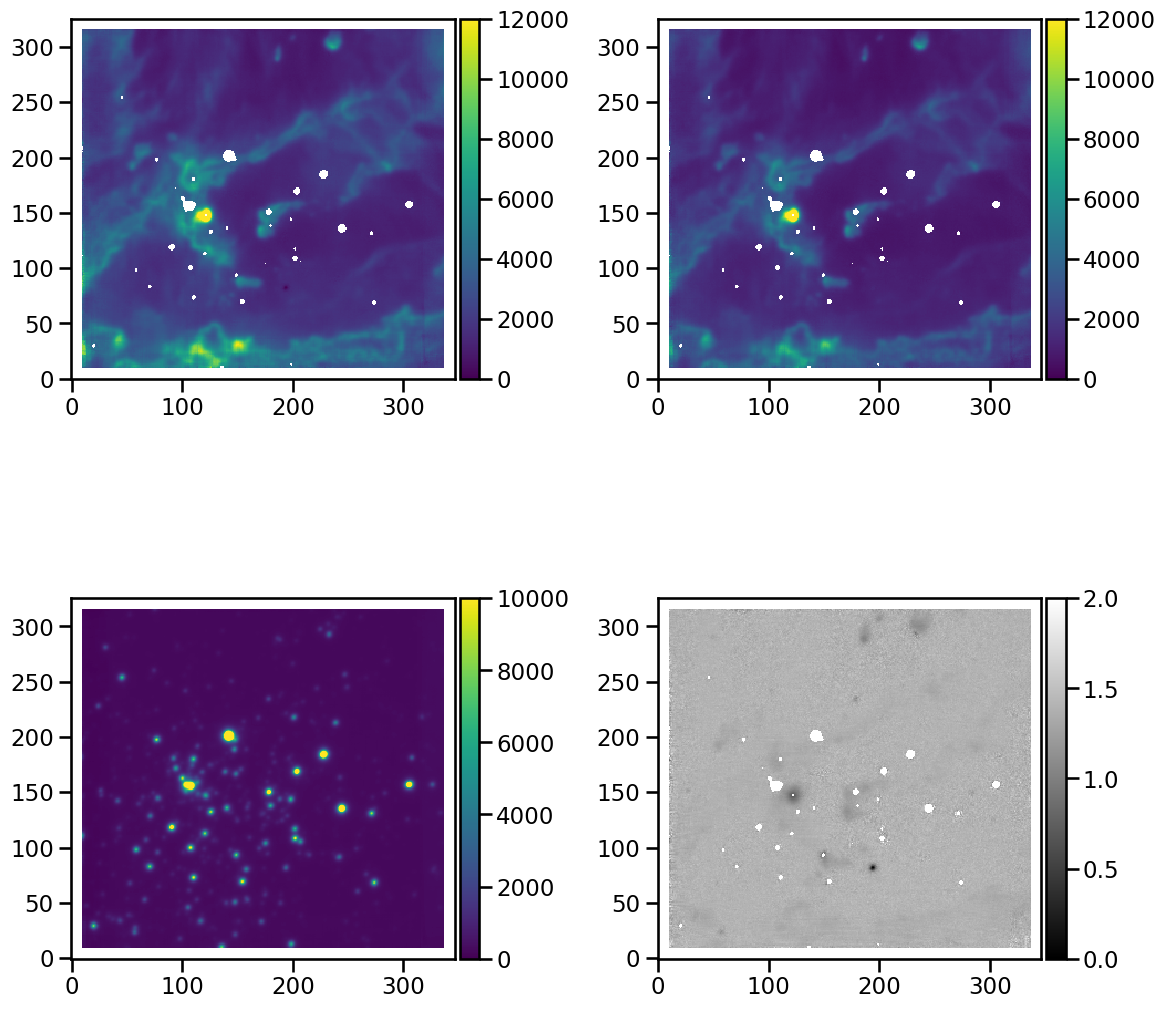

In [8]:
n = 1
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
im6716.rebin(n).plot(vmin=-10, vmax=12000, ax=axes[0, 0], colorbar="v")
im6731.rebin(n).plot(vmin=-10, vmax=12000, ax=axes[0, 1], colorbar="v")
imcont.rebin(n).plot(vmin=0, vmax=1e4, ax=axes[1, 0], colorbar="v")
(im6716.rebin(n) / im6731.rebin(n)).plot(
    ax=axes[1, 1],
    vmin=0.0,
    vmax=2.0,
    cmap="gray",
    colorbar="v",
)
fig.tight_layout()

Text(0.5, 0.98, 'Correlation between [S II] 6731 and 6716 brightness')

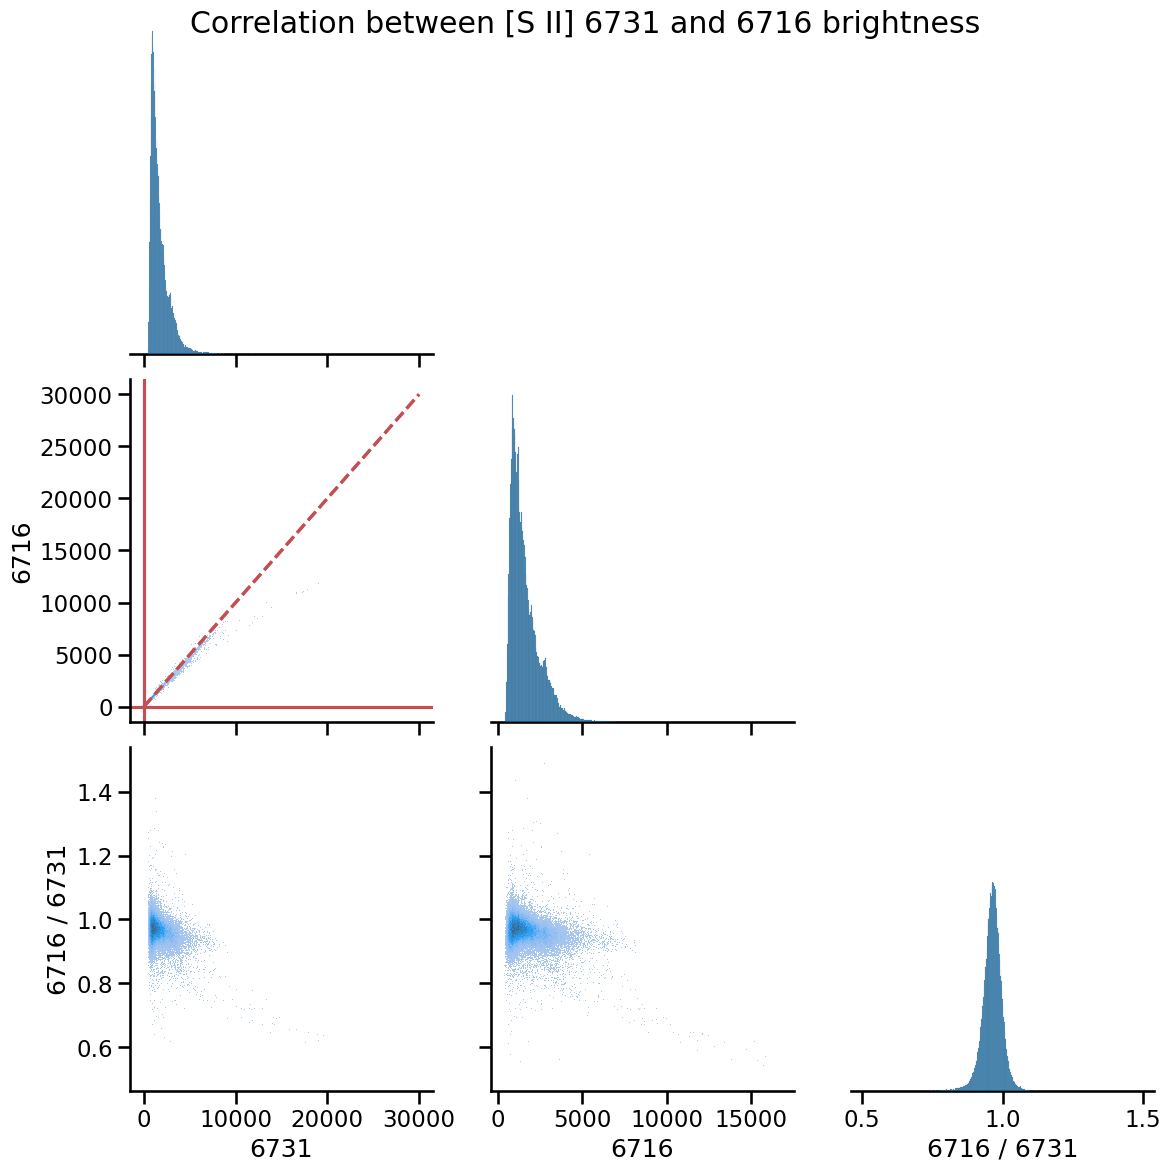

In [9]:
n = 1

imx = im6731.rebin(n)
imy = (im6716 / 1.44).rebin(n)

imin, imax = -10, 30000
m = (imx.data < imax) & (imy.data < imax)
m = m & (imx.data > imin) & (imy.data > imin)
m = m & (imy.data / imx.data > 0.5) & (imy.data / imx.data < 1.5)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6731": imx.data[m],
        "6716": imy.data[m],
        "6716 / 6731": imy.data[m] / imx.data[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([imin, imax], [imin, imax], "--", color="r")
g.axes[1, 0].plot([imin, imax], [imin, imax], "--", color="r")
g.fig.suptitle("Correlation between [S II] 6731 and 6716 brightness")

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


Text(0.5, 0.98, 'Correlation between [S II] 6716 / 6731 sum and Ha brightness')

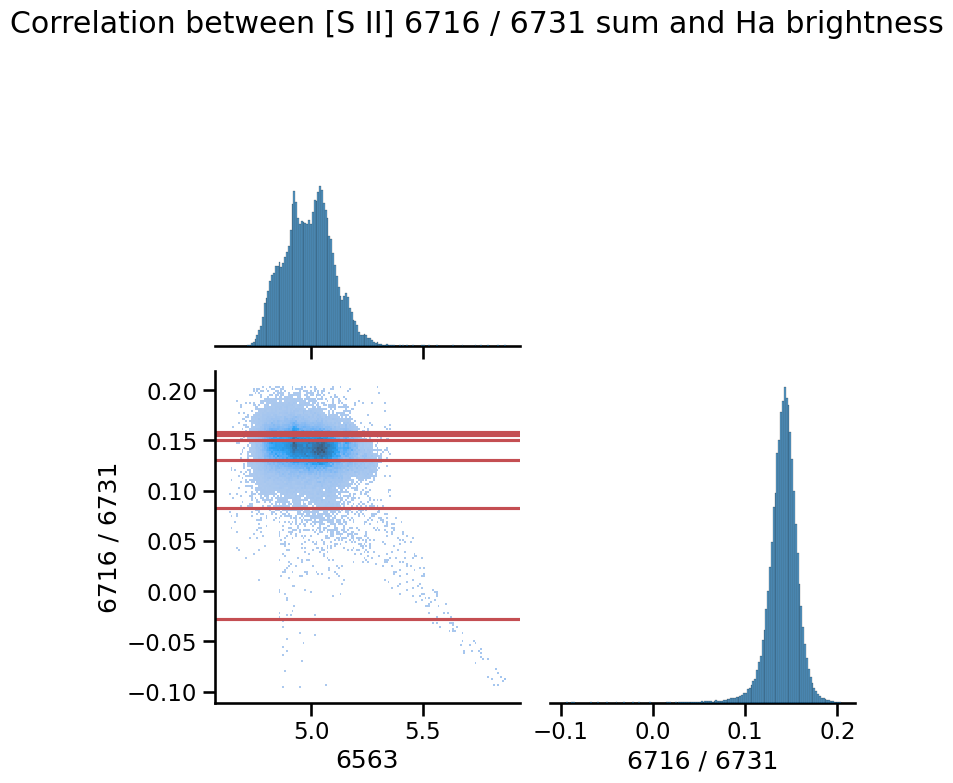

In [10]:
n = 1
imx = imha.rebin(n)
imy = im6716.rebin(n) / im6731.rebin(n)

m = (imy.data > 0.8) & (imy.data < 1.6)
m = m & (imx.data < 1.5e6)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6563": np.log10(imx.data[m]),
        "6716 / 6731": np.log10(imy.data[m]),
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imx.data[m],
        bins=150,
    ),
    diag_kws=dict(
        weights=imx.data[m],
        bins=150,
    ),
)
for R in Rgrid:
    g.axes[1, 0].axhline(np.log10(R), color="r")
g.fig.suptitle("Correlation between [S II] 6716 / 6731 sum and Ha brightness")

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


Text(0.5, 0.98, 'Correlation between [S II] 6716 / 6731 sum and Ha brightness')

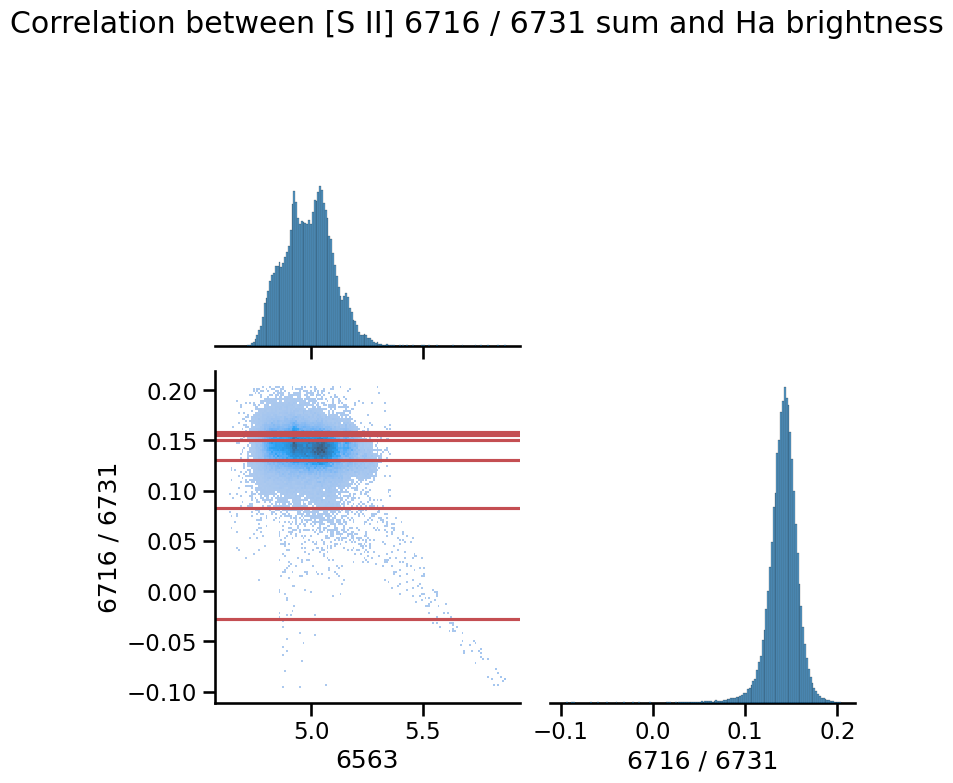

In [11]:
n = 1
imx = imha.rebin(n)
imy = im6716.rebin(n) / im6731.rebin(n)

m = (imy.data > 0.8) & (imy.data < 1.6)
m = m & (imx.data < 1.5e6)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6563": np.log10(imx.data[m]),
        "6716 / 6731": np.log10(imy.data[m]),
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imx.data[m],
        bins=150,
    ),
    diag_kws=dict(
        weights=imx.data[m],
        bins=150,
    ),
)
for R in Rgrid:
    g.axes[1, 0].axhline(np.log10(R), color="r")
g.fig.suptitle("Correlation between [S II] 6716 / 6731 sum and Ha brightness")

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


Text(0.5, 0.98, 'Correlation between [S II] 6716 / 6731 ratio and Ha brightness')

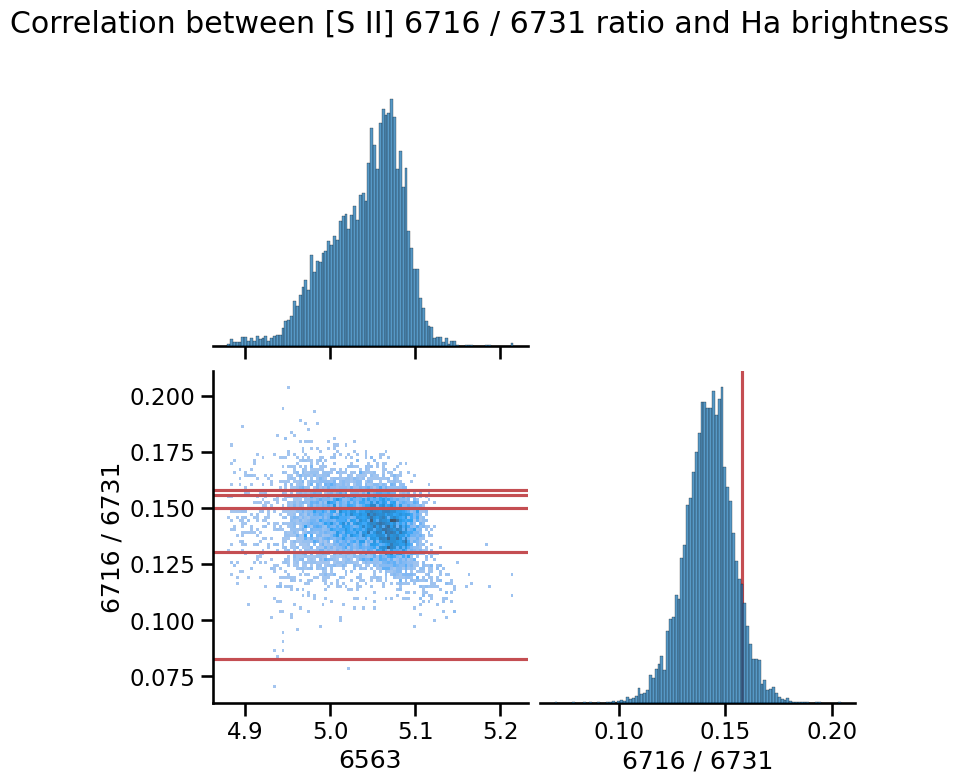

In [12]:
xslice, yslice = slice(230, 300), slice(144, 245)

n = 1

imx = imha[yslice, xslice].rebin(n)
imy = im6716[yslice, xslice].rebin(n) / im6731[yslice, xslice].rebin(n)

m = (imy.data > 1.1) & (imy.data < 2)
m = m & (imx.data < 1e6)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6563": np.log10(imx.data[m]),
        "6716 / 6731": np.log10(imy.data[m]),
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imx.data[m],
        bins=100,
    ),
    diag_kws=dict(
        weights=imx.data[m],
        bins=100,
    ),
)
g.axes[1, 1].axvline(np.log10(Rgrid[0]), color="r")
for R in Rgrid[:-1]:
    g.axes[1, 0].axhline(np.log10(R), color="r")

g.fig.suptitle("Correlation between [S II] 6716 / 6731 ratio and Ha brightness")

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


Text(0.5, 0.98, 'Correlation between [S II] 6716 / 6731 ratio and Ha brightness')

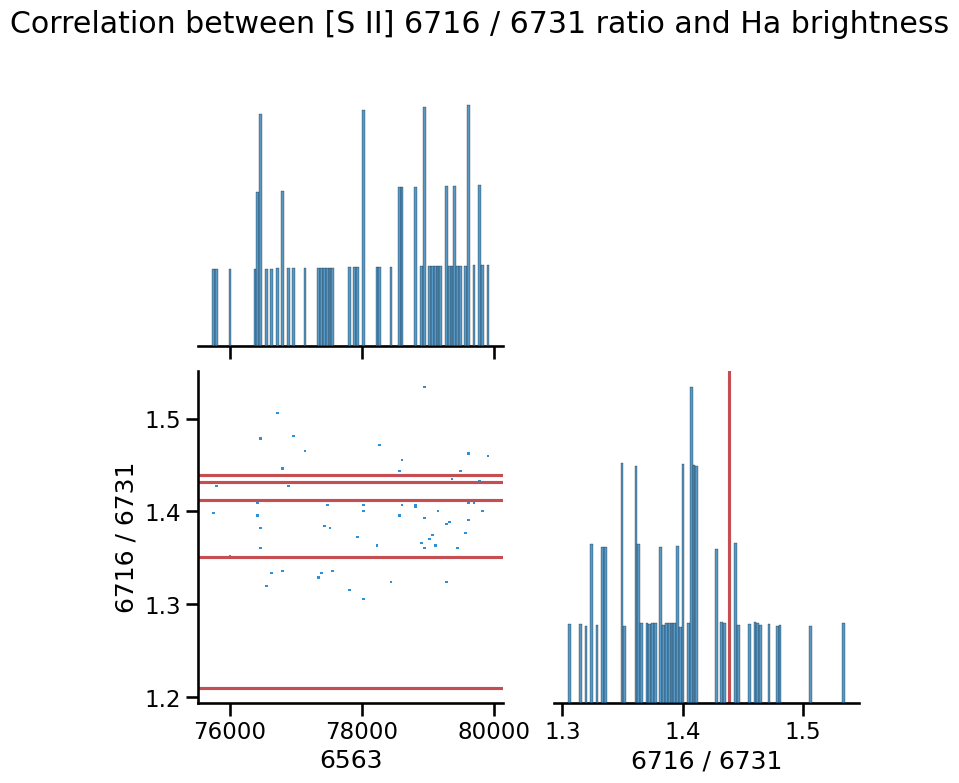

In [13]:
xslice, yslice = slice(230, 300), slice(144, 245)

n = 1

imx = imha[yslice, xslice].rebin(n)
imy = im6716[yslice, xslice].rebin(n) / im6731[yslice, xslice].rebin(n)

m = (imy.data > 1.1) & (imy.data < 2)
m = m & (imx.data < 80000)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6563": imx.data[m],
        "6716 / 6731": imy.data[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imx.data[m],
        bins=100,
    ),
    diag_kws=dict(
        weights=imx.data[m],
        bins=100,
    ),
)
g.axes[1, 1].axvline(Rgrid[0], color="r")
for R in Rgrid[:-1]:
    g.axes[1, 0].axhline(R, color="r")

g.fig.suptitle("Correlation between [S II] 6716 / 6731 ratio and Ha brightness")

So, in the bow shock region, we see ratios as low as 1.3 in the brightest parts, but these are globule surfaces.  The bulk of the emission has around 1.4

In [14]:
s2.getTemDen([1.4, 1.3, 0.8], tem=12000, wave1=6716, wave2=6731)

array([  45.20353656,  162.86088958, 1705.88138223])

So the density is about 50 +/- 30 pcc in the diffuse gas.  We get ten times higher density in the case of Source E, which has a ratio as low as 0.8

### Make a map of [S II] density

In [15]:
r_s2_grid = np.linspace(0.5, 1.44, 1001)
n_s2_grid = s2.getTemDen(r_s2_grid, tem=12000.0, wave1=6716, wave2=6731)

In [16]:
n_s2_grid

array([1.40424705e+04, 1.38947675e+04, 1.37382380e+04, ...,
       6.72335754e+00, 6.72335754e+00, 6.72335754e+00])

In [17]:
iew6716 = imcont / (1.25 * im6716)

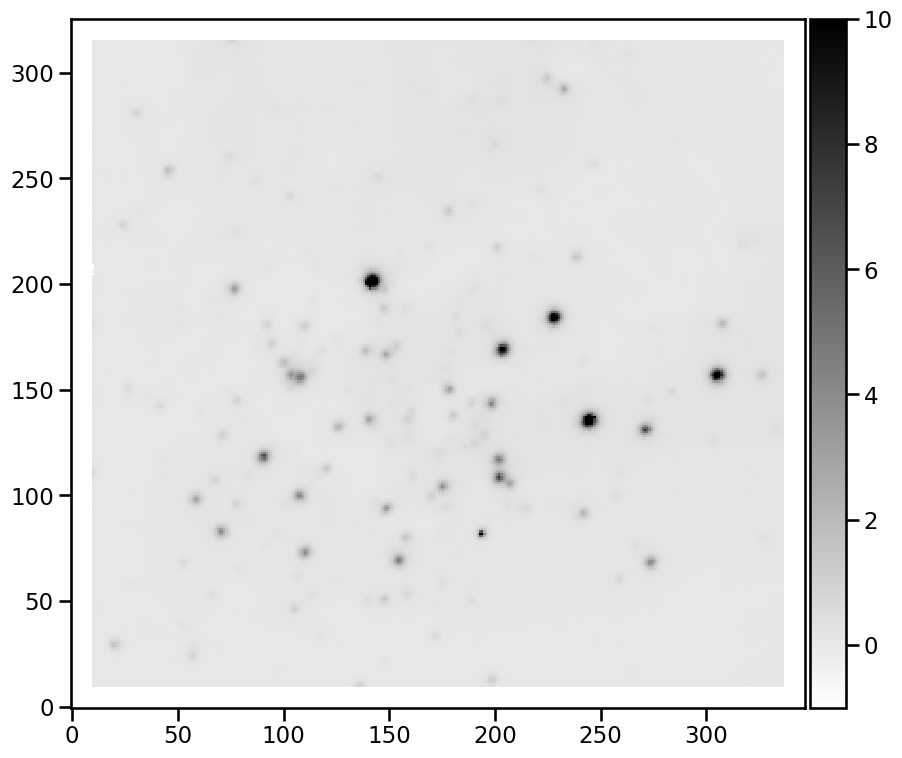

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
iew6716.plot(colorbar="v", cmap="gray_r", scale="linear", vmin=-1.0, vmax=10.0)

In [19]:
fixmask = im6716.mask | (iew6716.data > 10.0) | (iew6716.data < -0.2)
fixmask[90:97, 147:152] = True
fixmask[79:86, 191:197] = True


im_n_sii = im6716.clone(data_init=np.empty)
im_n_sii.mask = fixmask
trim_edges(im_n_sii, 10)
im_n_sii.data[~fixmask] = np.interp(
    im6716.data[~fixmask] / im6731.data[~fixmask],
    r_s2_grid,
    n_s2_grid,
    left=np.nan,
    right=np.nan,
)
im_n_sii.mask = im_n_sii.mask | ~np.isfinite(im_n_sii.data)

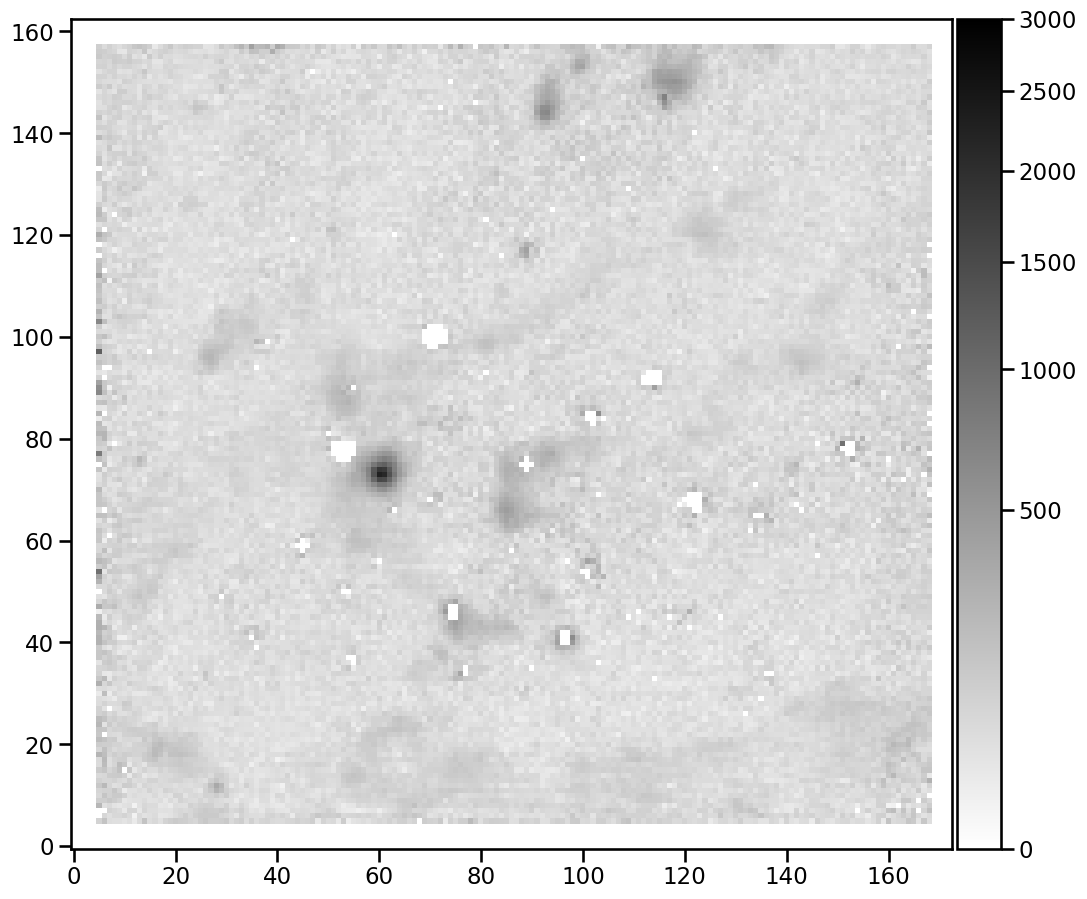

In [20]:
fig, ax = plt.subplots(figsize=(12, 12))
im_n_sii.rebin(2).plot(colorbar="v", cmap="gray_r", scale="sqrt", vmin=0.0, vmax=3000.0)

This seems to be good enough in some of the diffuse regions. although it is way to noisy in the faint parts.

In [21]:
im_n_sii.write(str(datadir) + "/ngc346-N-sii.fits", savemask="nan")

In [22]:
im_T_siii = Image(str(datadir / "ngc346-T-siii.fits"))
imhb = Image(str(datadir / "ngc346-hi-4861-correct.fits"))

Text(0.5, 0.98, 'Temperature vs Density')

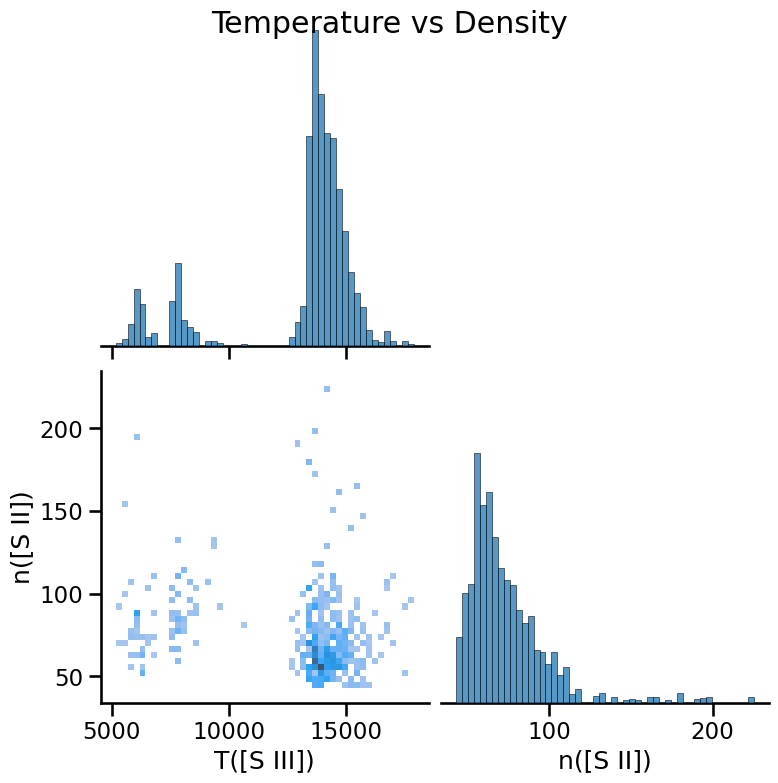

In [23]:
n = 16
imx = im_T_siii.rebin(n)
imy = im_n_sii.rebin(n)
imz = imhb.rebin(n)

m = ~imx.mask & ~imy.mask
m = m & (imx.data > 5000) & (imx.data < 20000)
m = m & (imy.data > 0) & (imy.data < 300)
df = pd.DataFrame(
    {
        "T([S III])": imx.data[m],
        "n([S II])": imy.data[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imz.data[m],
        bins=50,
    ),
    diag_kws=dict(
        weights=imz.data[m],
        bins=50,
    ),
)
g.fig.suptitle("Temperature vs Density")

## He II emission measure

In [24]:
he2 = pn.RecAtom("He", 2)
he1 = pn.RecAtom("He", 1)
h1 = pn.RecAtom("H", 1)

In [129]:
e4686 = he2.getEmissivity(tem=[12500, 15500], den=1, wave=4686)
e4861 = h1.getEmissivity(tem=[12500, 15500], den=1, wave=4861)
e5875 = he1.getEmissivity(tem=[12500, 15500], den=1, wave=5876)
e4686, e4861, e5875

(array([1.20300000e-24, 9.59135484e-25]),
 array([1.01400000e-25, 8.33922581e-26]),
 array([1.31541290e-25, 1.03205588e-25]))

From the other notebook, we measure 5875 / 4861 = 0.108 +/- 0.001

Whereas the ratio of emissivities is

In [26]:
e5875 / e4861

array([1.29725138, 1.23759196])

This implies a He abundance of

In [27]:
np.array([0.107, 0.108, 0.109])[None, :] / (e5875 / e4861)[:, None]

array([[0.08248209, 0.08325295, 0.08402381],
       [0.08645822, 0.08726624, 0.08807426]])

From Table 5 of Valerdi+ (2019), they have a He+ abundance of 10.915 or 10.917, with error of +/- 0.004 , so:

In [28]:
10 ** (np.array([10.915, 10.917]) - 12.0)

array([0.08222426, 0.08260379])

They find a small He++ abundance of

In [29]:
f"He++/H+ = {10**(8.30 - 12.0):.3e}; He++/He+ = {10**(8.30 - 10.915):.3e}"

'He++/H+ = 1.995e-04; He++/He+ = 2.427e-03'

In the bow shock I measure 4686 / 4861 = 0.015 or so, which would be 1.5 on a scale of Hβ = 100.  Mabel's Table 2 gives 0.24, which is 6 times less. This is consistent with the general value we find away from the bow's inner edge.

So, I can work out my own He++/H+ abundance:

In [30]:
y_heiii_hii = 0.015 / (e4686 / e4861)
y_heiii_heii = y_heiii_hii / 0.08167471
f"Bow shock He++/H+ = {np.round(y_heiii_hii, 4)}; He++/He+ = {np.round(y_heiii_heii, 4)}"

'Bow shock He++/H+ = [0.0013 0.0013]; He++/He+ = [0.0155 0.016 ]'

In other words, the He++ emission measure, $\int n(\mathrm{He^{++}})\, n_\mathrm{e}\, dz$, is ony 2.5% of the total $\int n(\mathrm{He^{+}})\, n_\mathrm{e}\, dz$.

*This is totally consistent, with the observed small change in 5875/4861, which is also about 2%*

**TODO**

- [ ] By assuming a path length, we can derive a density
- [ ] We can do the same with [Ar IV] and [Ar III]
- [ ] Ask Mabel to look at her slit A to see if she sees the He II and [Ar IV] signatures of the bow shock.  Also, maybe measure [O III] temperature to see if it goes up

### Conversion to a density

We want the surface brightness of He++ in physical units.

MUSE flux units are $10^{-20}\ \mathrm{erg\ s^{-1}\ cm^{-2}\ Å^{-1}\ pix^{-1}}$ in the cube, but we have summed over wavelength pixels, which are 1.4 Å.  The spatial pixels are 0.2 arcsec.

In [31]:
import astropy.units as u

In [32]:
muse_bright_unit = 1e-20 * 1.4 * u.erg / u.s / u.cm ** 2 / (0.2 * u.arcsec) ** 2

In [33]:
im4686 = Image(str(datadir / "ngc346-heii-4686-correct.fits"))
im5875 = Image(str(datadir / "ngc346-hei-5875-correct.fits"))
imhb = Image(str(datadir / "ngc346-hi-4861-correct.fits"))
imariv = Image(str(datadir / "ngc346-ariv-4711-plus-4740-correct.fits"))
imariii = Image(str(datadir / "ngc346-ariii-7136-correct.fits"))
imoiii = Image(str(datadir / "ngc346-oiii-5007-bin01-sum.fits"))

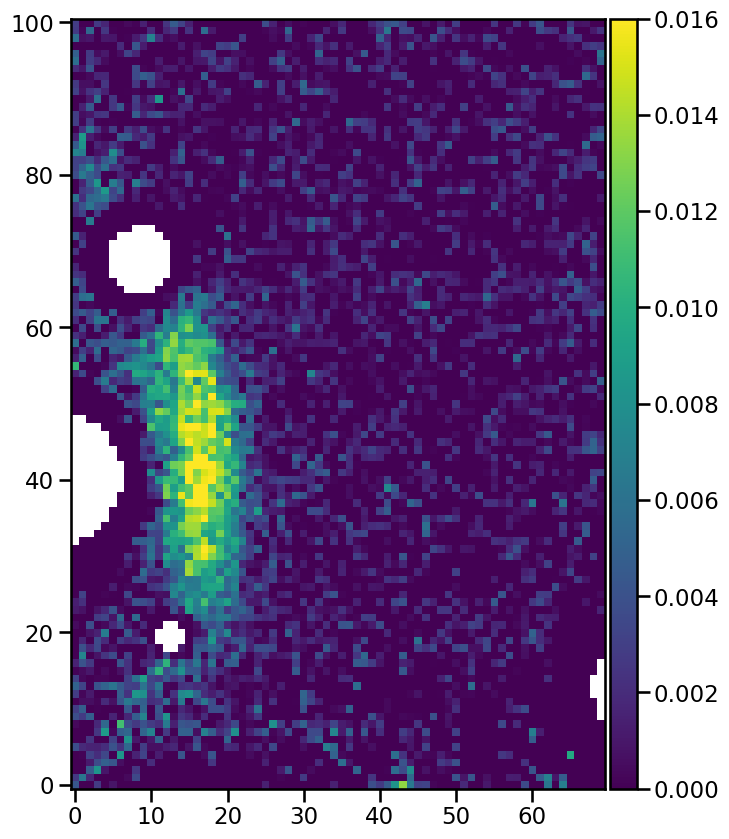

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
(im4686 / imhb)[yslice, xslice].plot(vmin=0.0, vmax=0.016, colorbar="v")

In [35]:
yslice

slice(144, 245, None)

In [36]:
xxslice = slice(None, None)
# yyslice = slice(164, 204) # original
# yyslice = slice(160, 210) # broader
# yyslice = slice(170, 200) # narrower
yyslice = slice(180, 200)  # top half ultra narrow


def make_profile(im):
    # return np.make(im[yyslice, xxslice].data, axis=0)
    return np.mean(im[yyslice, xxslice].data, axis=0)


heii_profile = make_profile(im4686)
hei_profile = make_profile(im5875)
hb_profile = make_profile(imhb)
ariv_profile = make_profile(imariv)
ariii_profile = make_profile(imariii)
oiii_profile = make_profile(imoiii)

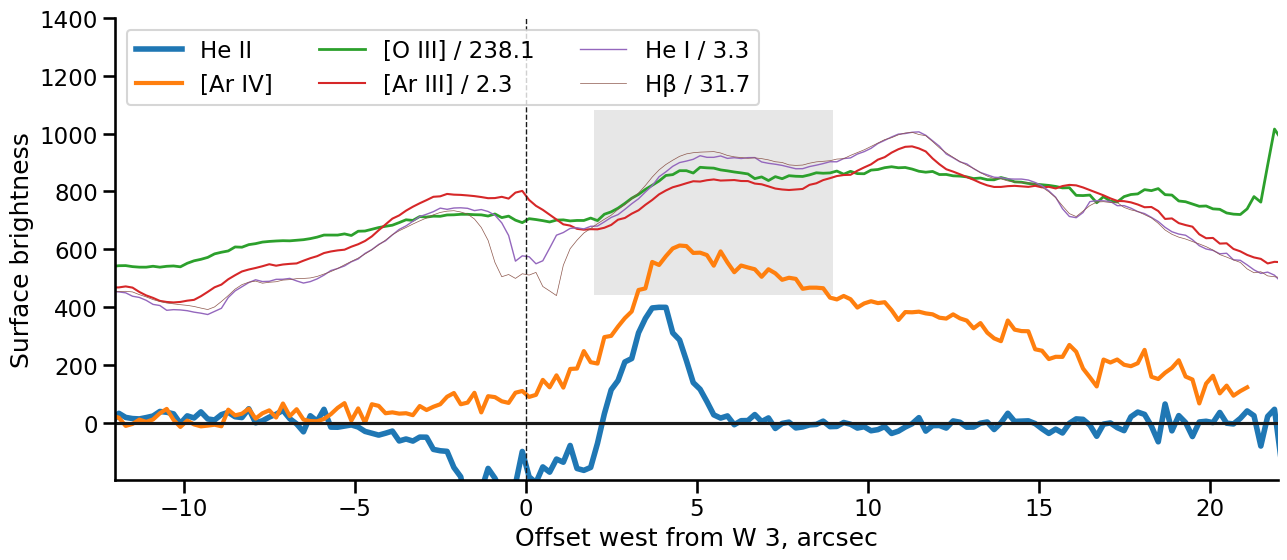

In [37]:
fig, ax = plt.subplots(figsize=(15, 6))
ix0 = 227.5
nx = len(heii_profile)
pos = (np.arange(nx) - ix0) * 0.2
pos2 = (np.arange(len(oiii_profile)) - ix0) * 0.2

ax.plot(pos, heii_profile, label="He II", lw=4)
ax.plot(pos, 1.00 * ariv_profile, label="[Ar IV]", lw=3)
fac = 3 * 0.0014
ax.plot(pos2, fac * oiii_profile, label=f"[O III] / {1/fac:.1f}", lw=2.0)
fac = 3 * 0.145
ax.plot(pos, fac * ariii_profile, label=f"[Ar III] / {1/fac:.1f}", lw=1.5)
fac = 3 * 0.100
ax.plot(pos, fac * hei_profile, label=f"He I / {1/fac:.1f}", lw=1.0)
fac = 3 * 0.0105
ax.plot(pos, fac * hb_profile, label=f"Hβ / {1/fac:.1f}", lw=0.5)


ax.axhline(0, color="k")

ax.axvline(0, color="k", lw=1, ls="dashed")
ax.axvspan(2.0, 9.0, 0.4, 0.8, color="k", alpha=0.1, linewidth=0, zorder=-100)
ax.legend(ncol=3, loc="upper left")

ax.set(
    xlabel="Offset west from W 3, arcsec",
    ylabel="Surface brightness",
    xlim=[-12, 22],
    ylim=[-199, 1400],
)
sns.despine()
fig.savefig(figdir / "ngc346-bow-shock-brightness-cuts.pdf")

From the profile graph above, the peak He II brightness is about 400 MUSE brightness units

In [39]:
peak_heii = muse_bright_unit * 400
peak_heii

<Quantity 1.4e-16 erg / (s arcsec2 cm2)>

From the image, the chord length through the bow is about 60 pixels.  We can assume that the line-of-sight depth is similar:

In [40]:
depth_heii = 60 * 0.2 * 61700 * u.au
depth_heii.to(u.pc)

<Quantity 3.58956049 pc>

Surface brightness assuming optically thin emission with isotropic line emissivity, $e(\lambda)$, is given by
$$
I(\lambda) = \int \frac{e(\lambda)\, n_e\, n_i}{4 \pi} \, dz
$$
where $e(\lambda)$ is in the units given by pyneb: `u.erg * u.cm**3 / u.s` and $n_e$, $n_i$ are the electron and ion densities.

Assume neutral fractions of He and H are negligible and hydrogen number density is $n$.  If the He abundance is $y = n(\mathrm{He}) / n(\mathrm{H})$ and the He++ ion fraction is $x_{++}$, then we have:
$$
n(\mathrm{He^{++}}) = y\, x_{++}\, n \quad \text{and} \quad n_e = [1 + y\, (1 + x_{++})]\, n
$$
implying that
$$
n(\mathrm{He^{++}}) \, n_e = n_e^2 \, \frac{y\, x_{++}}{1 + y\, (1 + x_{++})}
\approx n_e^2 \, \frac{y}{1 + 2 y}
$$

So, with homogeneous conditions, we have
$$
I(4686) = 
\frac{e(4686)}{4\pi}\, 
\frac{y\, x_{++}}{1 + (1 + x_{++}) y} 
\, n_e^2 \, \delta z
$$
which can be solved for density to yield
$$
n_e = \left[
\frac{4\pi\, I(4686)}{\delta z\, e(4686)} \, \frac{1 + (1 + x_{++}) y}{x_{++}\,y}
\right]^{1/2}
$$

We can take the helium abundance from above and get ...

In [41]:
pn_e_units = u.erg * u.cm ** 3 / u.s
yHe = 0.0824
ne = np.sqrt(
    4
    * np.pi
    * u.sr
    * peak_heii
    / (depth_heii.cgs * e4686 * pn_e_units)
    * (1 + 2 * yHe)
    / yHe
).to(u.cm**-3)
ne

<Quantity [8.91102031, 9.97976392] 1 / cm3>

**So electron density of 11 pcc!**

Note, however that this assumes that the helium is 100% doubly ionized in the 4686 emitting region. If it is only partially ionized, then this is alower limit (density would scale approximately as $x_{++}^{-1/2}$).

#### Find the He II flux and the He++ ionizing luminosity



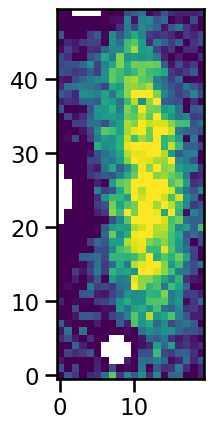

In [42]:
im4686[160:210, 235:255].plot(vmin=0, vmax=400)

In [43]:
muse_flux_unit = 1e-20 * 1.4 * u.erg / u.s / u.cm ** 2

In [44]:
cutout = im4686[160:210, 235:255]
m = (cutout.data > 0.0) & ~cutout.mask
F_heii = muse_flux_unit * np.sum(cutout.data[m])
F_heii

<Quantity 2.03703113e-15 erg / (s cm2)>

In [45]:
D_lmc = 61700 * u.pc

In [46]:
L_heii = 4 * np.pi * D_lmc.cgs ** 2 * F_heii
L_heii

<Quantity 9.27852514e+32 erg / s>

In [47]:
L_heii.to(u.solLum)

<Quantity 0.24238571 solLum>

Effective recomb rate:

In [48]:
import astropy.constants as constants

In [49]:
hnu4686 = (constants.h * constants.c / (4686 * u.Angstrom)).cgs
hnu4686

<Quantity 4.23910768e-12 erg>

In [50]:
alpha_eff_4686 = e4686 * pn_e_units / hnu4686
alpha_eff_4686

<Quantity [2.83786139e-13, 2.26258816e-13] cm3 / s>

In [51]:
pn.atomicData.getAllAvailableFiles("He2")

['* 3he_ii_atom_cloudy.dat',
 '* 3he_ii_coll_cloudy.dat',
 '* he_ii_rec_SH95.hdf5',
 'he_ii_rec_P91.func',
 'he_ii_rec_SH95-caseA.fits',
 'he_ii_rec_SH95-caseA.hdf5',
 'he_ii_rec_SH95.fits',
 'he_ii_trc_SH95-caseA.dat',
 'he_ii_trc_SH95-caseB.dat']

It only works as follows:

In [52]:
pn.atomicData.setDataFile("he_ii_trc_SH95-caseB.dat")
alphaB_He_plus = pn.RecAtom("He", 2).getTotRecombination(tem=[1.25e4, 1.55e4], den=100)
alphaB_He_plus *= u.cm ** 3 / u.s
alphaB_He_plus

<Quantity [1.29700000e-12, 1.10235464e-12] cm3 / s>

Solid angle: assume a +/- 75 degree end cap.

In [53]:
Omega_over_4pi = (1 - np.cos(75 * u.deg)) / 2
Omega_over_4pi

<Quantity 0.37059048>

$$
Q \frac{\Omega}{4\pi} = \int_{\mathcal{V}} n_e \, n_i \, \alpha_B\, d\mathcal{V}
$$
and
$$
L(4686) = \int_{\mathcal{V}} n_e \, n_i \, e(4686)\, d\mathcal{V}
$$
so that
$$
Q = \frac{\alpha_B \, L(4686)} {e(4686)\, (\Omega/4\pi)}
$$

In [54]:
Q2 = alphaB_He_plus * L_heii / (e4686 * pn_e_units) / Omega_over_4pi
Q2

<Quantity [2.69934902e+45, 2.87757114e+45] 1 / s>

## Alternative route to density from Balmer lines

We can estimate the bow shock shell emission measure from the jump in the surface brightness of H beta, say. This has the advantage that we know that the hydrogen is fully ionized.

In [119]:
jump_hb = 31.7 * 300 * muse_bright_unit
f"{jump_hb=}"

'jump_hb=<Quantity 3.3285e-15 erg / (s arcsec2 cm2)>'

The 300 is my estimate from the above figure of the Hb jump at the bow shock inner edge, while the 31.7 is what we divided Hb by before plotting it. So this should be the surface brightness of Hb, which should be EM times emission coefficient / 4 pi

In [120]:
EM = jump_hb * (4 * np.pi * u.sr).to(u.arcsec**2) / (e4686 * pn_e_units)
EM

<Quantity [1.47925506e+21, 1.85536232e+21] 1 / cm5>

There are two answers, corrending to assumed temperature of 12,500 of 15,500 K

In [121]:
np.sqrt(EM / depth_heii).to(u.cm**-3)

<Quantity [11.55648131, 12.9425084 ] 1 / cm3>

So that gives exactly the same value for the density, which means the He must be fully doubly ionized

### Sanity check from He II / H I

In principle, we can come to the same conclusion starting from the 4686/4861 ratio, so long as we account for the fraction of the H beta emission that comes from the bow shock.

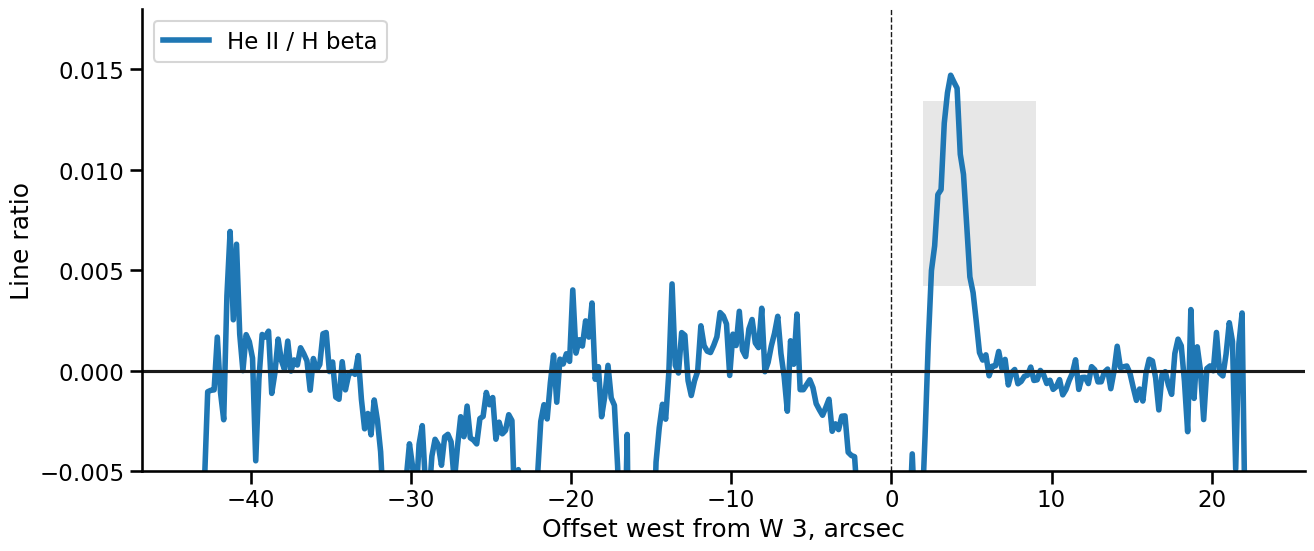

In [128]:
fig, ax = plt.subplots(figsize=(15, 6))
ix0 = 227.5
nx = len(heii_profile)
pos = (np.arange(nx) - ix0) * 0.2
imargin = 10
ratio = heii_profile / hb_profile
ax.plot(pos[imargin:], ratio[imargin:], label="He II / H beta", lw=4)

ax.axhline(0, color="k")

ax.axvline(0, color="k", lw=1, ls="dashed")
ax.axvspan(2.0, 9.0, 0.4, 0.8, color="k", alpha=0.1, linewidth=0, zorder=-100)
ax.legend(ncol=3, loc="upper left")

ax.set(
    xlabel="Offset west from W 3, arcsec",
    ylabel="Line ratio",
#    xlim=[-12, 22],
    ylim=[-0.005, 0.018],
)
sns.despine()
fig.savefig(figdir / "ngc346-bow-shock-heii-hbeta-cuts.pdf")

So the peak ratio is about 0.015. We have to divide this by the fraction of H beta that comes frm the bow shock.

In [130]:
hb_bow_frac = 0.3
heii_hb_bow_max = np.max(ratio[imargin:]) / hb_bow_frac
heii_hb_bow_max

0.04902239835614311

Then we should have
$$
\texttt{heii\_hb\_bow\_max} = 
\frac{I(4686)}{I(4681)} =
\frac{
\int e(4686)\, n(\mathrm{He^{++}})\, n_e\, dz
}{
\int e(4861)\, n(\mathrm{H^+})\, n_e\, dz
}
\approx
\frac{e(4686)}{e(4861)}\,
y(\mathrm{He})\,
x(\mathrm{He}^{++})
$$

In [131]:
yhe = 0.08325295
xheiii = (heii_hb_bow_max * e4861) / (yhe * e4686)
xheiii

array([0.04963263, 0.05119655])

Note that this assumes that the line-of-sight path length is the same for He++ and for H+. In reality it may be longer for H+ because the thickness of the emitting shell is greater. In the thin shell approximation, the ratio of path lengths is the sqrt of the ratio of thickness. 

## Also do profiles of low ionization lines

In [55]:
im6300 = Image(str(datadir / "ngc346-oi-6300-bin01-sum.fits"))
im5518 = Image(str(datadir / "ngc346-cliii-5518-bin01-sum.fits"))
im5538 = Image(str(datadir / "ngc346-cliii-5538-bin01-sum.fits"))
im9069 = Image(str(datadir / "ngc346-siii-9069-bin01-sum.fits"))

In [56]:
oi_profile = make_profile(im6300)
cliiis_profile = make_profile(im5518)
cliiil_profile = make_profile(im5538)
siis_profile = make_profile(im6716)
siil_profile = make_profile(im6731)
siii_profile = make_profile(im9069)

sii_profile = 0.5 * (siis_profile + siil_profile)
cliii_profile = 0.5 * (cliiis_profile + cliiil_profile)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


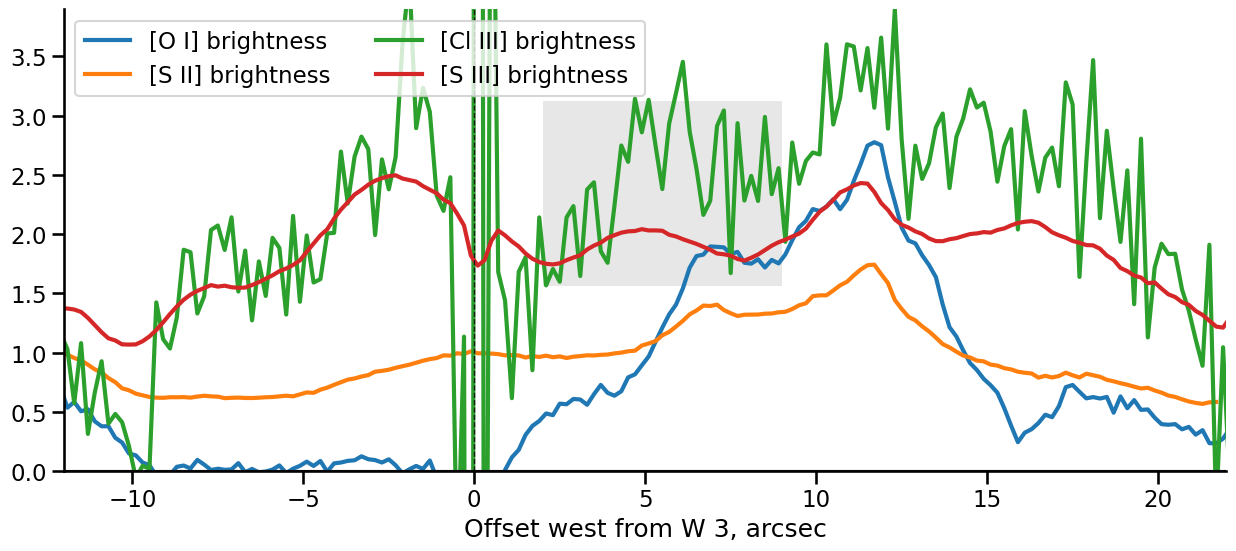

In [57]:
fig, ax = plt.subplots(figsize=(15, 6))
ix0 = 227.5
nx = len(oi_profile)
pos = (np.arange(nx) - ix0) * 0.2
pos2 = (np.arange(len(siil_profile)) - ix0) * 0.2

ax.plot(pos, 1.0 * oi_profile / np.median(oi_profile), label="[O I] brightness", lw=3)
ax.plot(
    pos2, 1.0 * sii_profile / np.median(sii_profile), label="[S II] brightness", lw=3
)
ax.plot(
    pos,
    1.7 * cliii_profile / np.median(cliii_profile),
    label="[Cl III] brightness",
    lw=3,
)
ax.plot(
    pos, 1.7 * siii_profile / np.median(siii_profile), label="[S III] brightness", lw=3
)


ax.axhline(0, color="k")

ax.axvline(0, color="k", lw=1, ls="dashed")
ax.axvspan(2.0, 9.0, 0.4, 0.8, color="k", alpha=0.1, linewidth=0, zorder=-100)
ax.legend(ncol=2, loc="upper left")

ax.set(
    xlabel="Offset west from W 3, arcsec",
    xlim=[-12, 22],
    ylim=[0, 3.9],
)
sns.despine()
fig.savefig(figdir / "ngc346-bow-shock-lowion-cuts.pdf")

## Ar ionization balance

We will calculate the conditions at the very peak of the [Ar IV] emission.

We need a very careful slection of the background (BG) and bow shock (BS) samples, since we want to make sure we are in the little triangle window where the intermediate ionization lines are not too contaminated by globule i-fronts and unrelated filaments.

In [58]:
i0, j0, w, h = 234, 200, 12, 8
bgbox = regions.RegionBoundingBox(
    iymin=j0 - h // 2,
    iymax=j0 + h // 2,
    ixmin=i0 - w // 2,
    ixmax=i0 + w // 2,
)
i0, j0, w, h = 250, 193, 8, 8
bsbox = regions.RegionBoundingBox(
    iymin=j0 - h // 2,
    iymax=j0 + h // 2,
    ixmin=i0 - w // 2,
    ixmax=i0 + w // 2,
)

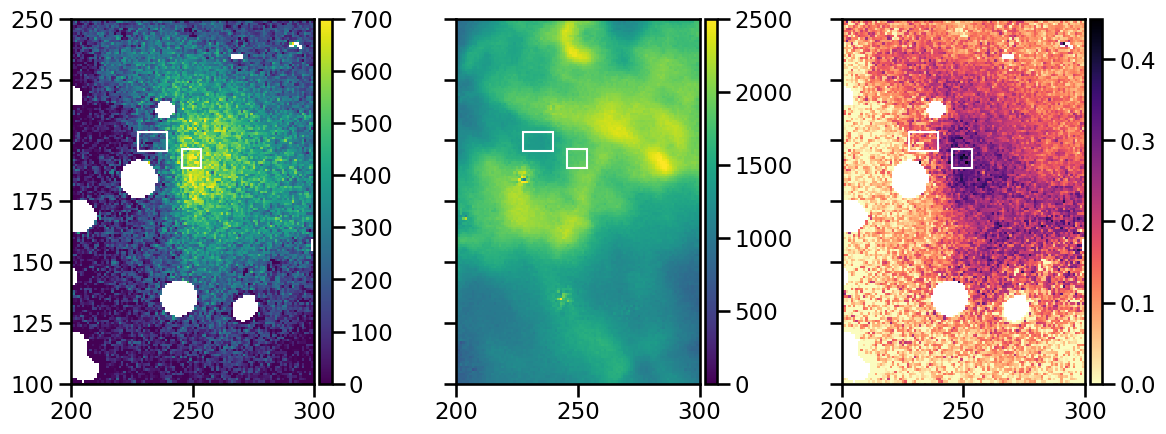

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
imariv.plot(ax=axes[0], vmin=0, vmax=700, colorbar="v")
imariii.plot(ax=axes[1], vmin=0, vmax=2500, colorbar="v")
(imariv / imariii).plot(ax=axes[2], vmin=0, vmax=0.45, cmap="magma_r", colorbar="v")
for ax in axes:
    bsbox.plot(ax=ax, color="w")
    bgbox.plot(ax=ax, color="w")
    ax.set(
        xlim=[200, 300],
        ylim=[100, 250],
    )
fig.tight_layout()

In [60]:
bs_slices, _ = bsbox.get_overlap_slices(imariv.shape)
bg_slices, _ = bgbox.get_overlap_slices(imariv.shape)

bs_ariv = imariv[bs_slices].data.mean()
bg_ariv = imariv[bg_slices].data.mean()
sbs_ariv = imariv[bs_slices].data.std()
sbg_ariv = imariv[bg_slices].data.std()

bs_slices, _ = bsbox.get_overlap_slices(imariii.shape)
bg_slices, _ = bgbox.get_overlap_slices(imariii.shape)
bs_ariii = imariii[bs_slices].data.mean()
bg_ariii = imariii[bg_slices].data.mean()
sbs_ariii = imariii[bs_slices].data.std()
sbg_ariii = imariii[bg_slices].data.std()

In [61]:
f"[Ar IV]: BS = {bs_ariv:.2f} +/- {sbs_ariv:.2f}, BG = {bg_ariv:.2f} +/- {sbg_ariv:.2f}"

'[Ar IV]: BS = 600.16 +/- 74.65, BG = 200.03 +/- 91.48'

In [62]:
f"[Ar III]: BS = {bs_ariii:.2f} +/- {sbs_ariii:.2f}, BG = {bg_ariii:.2f} +/- {sbg_ariii:.2f}"

'[Ar III]: BS = 1832.30 +/- 45.06, BG = 1393.94 +/- 39.97'

In [63]:
BS_ariv = bs_ariv - bg_ariv
sBS_ariv = np.hypot(sbs_ariv, sbg_ariv)

BS_ariii = bs_ariii - bg_ariii
sBS_ariii = np.hypot(sbs_ariii, sbg_ariii)

BS_ar_iv_iii = BS_ariv / BS_ariii
sBS_ar_iv_iii = BS_ar_iv_iii * np.hypot(sBS_ariii / BS_ariii, sBS_ariv / BS_ariv)

f"BG-subtracted BS: [Ar IV] / [Ar III] = {BS_ar_iv_iii:.3f} +/- {sBS_ar_iv_iii:.3f}"

'BG-subtracted BS: [Ar IV] / [Ar III] = 0.913 +/- 0.297'

In [64]:
ar4 = pn.Atom("Ar", 4)
ar3 = pn.Atom("Ar", 3)

First T is for BG nebula. Second and third are lower and upper limits for bow shock.  See analysis of [Ar IV] temperature in `10-01` notebook

In [65]:
Ts = [12500, 14000, 16000]
e4711 = ar4.getEmissivity(tem=Ts, den=10.0, wave=4711)
e4740 = ar4.getEmissivity(tem=Ts, den=10.0, wave=4740)
e7136 = ar3.getEmissivity(tem=Ts, den=10.0, wave=7136)

In [66]:
e4711 + e4740

array([1.43041577e-20, 1.77455634e-20, 2.21544997e-20])

In [67]:
e7136

array([2.00311981e-20, 2.25238108e-20, 2.52671484e-20])

So the emissivity is very similar, strangely.

Anyway, we should have:
$$
\frac {n(\mathrm{Ar^{3+}})} {n(\mathrm{Ar^{2+}})}
=
\frac{I(4711 + 4740)}{I(7136)}
\, \frac{e(7136)}{e(4711 + 4740)}
$$

In [68]:
e7136 / (e4711 + e4740)

array([1.40037593, 1.26926434, 1.14049736])

So the T uncertainty of +/- 1000 K would give +/- 10% uncertainty in the emissivity ratio. For the time being we take the middle value:

In [69]:
Ar3p_over_Ar2p = BS_ar_iv_iii * (e7136 / (e4711 + e4740))[1]
Ar3p_over_Ar2p

1.158583094161645

Or, close enough to unity.  So, at the inner edge of the bow shock we have 50% Ar++ and 50% Ar+++. We can use this to constrain the stellar spectrum if we run some Cloudy models

Now do the same, but for the BG nebula

In [70]:
Ar3p_over_Ar2p_BG = (bg_ariv / bg_ariii) * (e7136 / (e4711 + e4740))[0]
Ar3p_over_Ar2p_BG

0.2009483343879394

So this implies 20% Ar+++ in the BG region.

However, these are both still integrals along the line of sight, so the actual variation in ionization might be larger.

For instance, the Ar+++ fraction might be higher than 50% at the inner edge.  We could do a LOS integration on the Cloudy emissivities to investigate this.

Likewise, the Ar+++ fraction in the BG might be lower than 0.2 since that could be due to contamination by the bow shock wing emission.

## Can we get a He I density?

In [71]:
dgrid = [1.0, 10.0, 100.0, 1000.0]
T0 = [11000, 13000, 18000]
he1.getEmissivity(tem=T0, den=dgrid, wave=5876) / he1.getEmissivity(
    tem=T0, den=dgrid, wave=6678
)

array([[3.52143762, 3.52143762, 3.52273521, 3.53264503],
       [3.5302056 , 3.5302056 , 3.5297992 , 3.53419086],
       [3.548379  , 3.548379  , 3.53549315, 3.49462034]])

In [72]:
he1.getEmissivity(tem=T0, den=dgrid, wave=4922) / he1.getEmissivity(
    tem=T0, den=dgrid, wave=5876
)

array([[0.09885076, 0.09885076, 0.09869156, 0.09562248],
       [0.1003275 , 0.1003275 , 0.09971259, 0.09410442],
       [0.1028182 , 0.1028182 , 0.10068853, 0.08872582]])

In [73]:
he1.getEmissivity(tem=T0, den=dgrid, wave=5048) / he1.getEmissivity(
    tem=T0, den=dgrid, wave=5876
)

array([[0.01533487, 0.01533487, 0.01539856, 0.01545717],
       [0.01685621, 0.01685621, 0.01687563, 0.01666441],
       [0.02038825, 0.02038825, 0.02011176, 0.01845355]])

In [74]:
im5048 = Image(str(datadir / "ngc346-hei-5048-bin01-sum.fits"))
im5876 = Image(str(datadir / "ngc346-hei-5875-bin01-sum.fits"))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


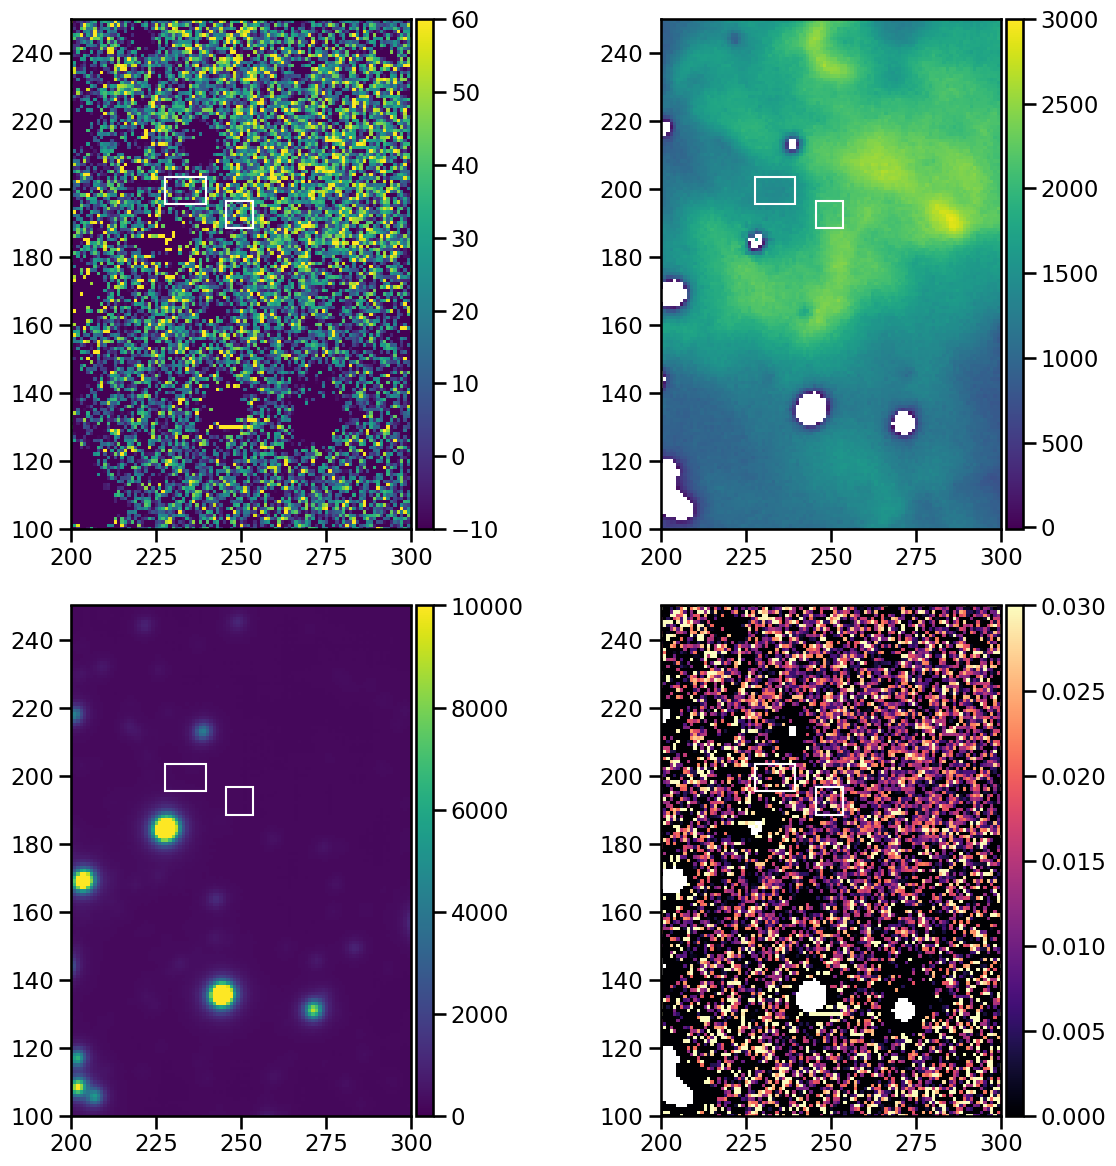

In [75]:
n = 1
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
im5048.rebin(n).plot(vmin=-10, vmax=60, ax=axes[0, 0], colorbar="v")
im5876.rebin(n).plot(vmin=-10, vmax=3000, ax=axes[0, 1], colorbar="v")
imcont.rebin(n).plot(vmin=0, vmax=1e4, ax=axes[1, 0], colorbar="v")
(im5048.rebin(n) / im5876.rebin(n)).plot(
    ax=axes[1, 1],
    vmin=0.0,
    vmax=0.03,
    cmap="magma",
    colorbar="v",
)
for ax in axes.flat:
    bsbox.plot(ax=ax, color="w")
    bgbox.plot(ax=ax, color="w")
    ax.set(
        xlim=[200, 300],
        ylim=[100, 250],
    )
fig.tight_layout()

In [76]:
yyslice = slice(164, 204)  # original
# yyslice = slice(160, 210) # broader
# yyslice = slice(170, 200) # narrower
# yyslice = slice(180, 200) # top half ultra narrow
hei_5048_profile = make_profile(im5048)
hei_5876_profile = make_profile(im5876)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


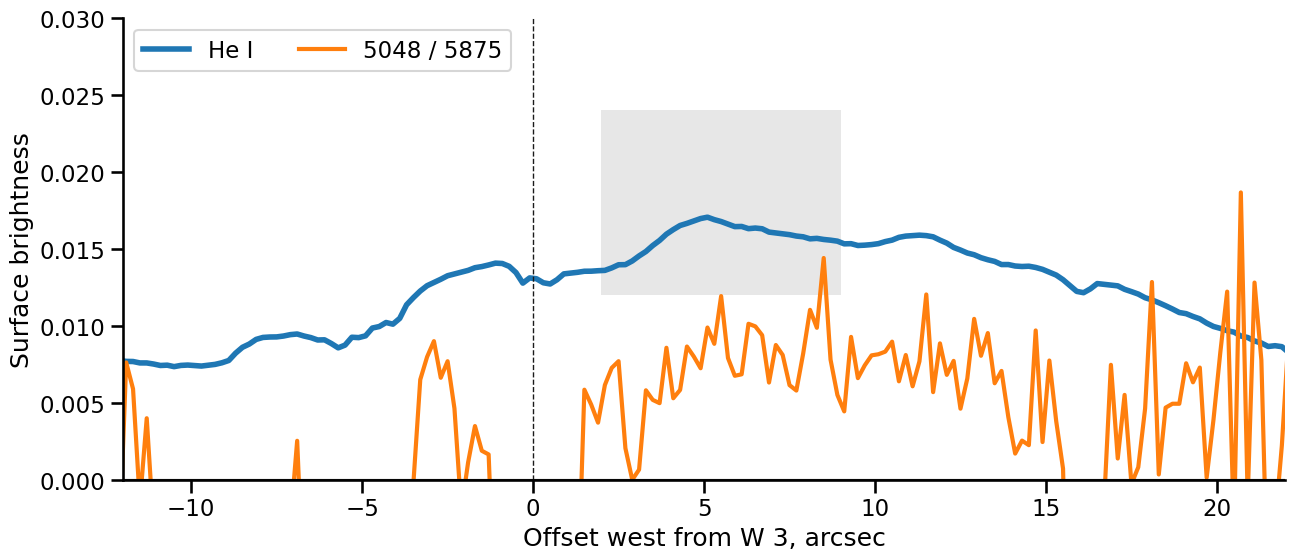

In [77]:
fig, ax = plt.subplots(figsize=(15, 6))
ix0 = 227.5
nx = len(hei_profile)
pos = (np.arange(nx) - ix0) * 0.2

ax.plot(pos, 0.01 * hei_5876_profile / np.median(hei_5876_profile), label="He I", lw=4)
ax.plot(pos, hei_5048_profile / hei_5876_profile, label="5048 / 5875", lw=3)

ax.axhline(0, color="k")

ax.axvline(0, color="k", lw=1, ls="dashed")
ax.axvspan(2.0, 9.0, 0.4, 0.8, color="k", alpha=0.1, linewidth=0, zorder=-100)
ax.legend(ncol=3, loc="upper left")

ax.set(
    xlabel="Offset west from W 3, arcsec",
    ylabel="Surface brightness",
    xlim=[-12, 22],
    ylim=[0, 0.03],
)
sns.despine()

In [79]:
bs_5048 = im5048[bs_slices].data.mean()
bs_5876 = im5876[bs_slices].data.mean()
bs_5048 / bs_5876

0.00934897973729834

In [80]:
bg_5048 = im5048[bg_slices].data.mean()
bg_5876 = im5876[bg_slices].data.mean()
bg_5048 / bg_5876

0.004546780169068951

These are all way lower than the theoretical values for reasonable temperatures.  Maybe the 5048 line is affected by underlying stellar absorption.

In [81]:
# yyslice = slice(164, 204) # original
# yyslice = slice(160, 210) # broader
# yyslice = slice(170, 200) # narrower
yyslice = slice(180, 200)  # top half ultra narrow
n_sii_profile = make_profile(im_n_sii)
T_siii_profile = make_profile(im_T_siii)
sii_profile = make_profile(im6731)
im9069 = Image(str(datadir / "ngc346-siii-9069-bin01-sum.fits"))
siii_profile = make_profile(im9069)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


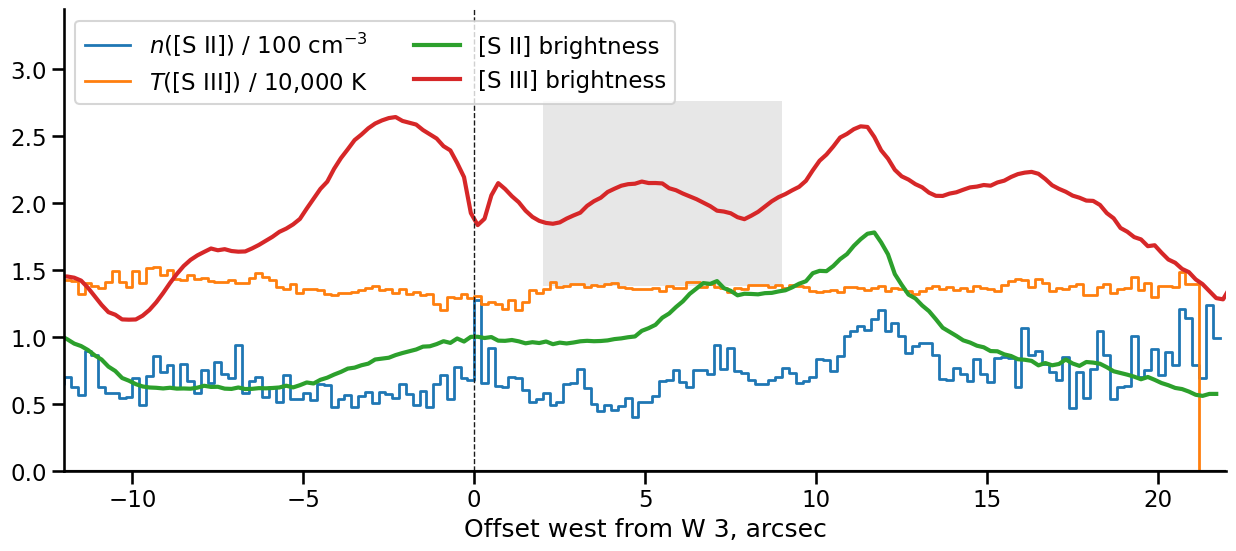

In [84]:
fig, ax = plt.subplots(figsize=(15, 6))
ix0 = 227.5
nx = len(sii_profile)
pos = (np.arange(nx) - ix0) * 0.2
pos2 = (np.arange(len(siii_profile)) - ix0) * 0.2

ax.plot(
    pos, 0.01 * n_sii_profile, ds="steps-mid", label="$n$([S II]) / 100 cm$^{-3}$", lw=2
)
ax.plot(
    pos2, 0.0001 * T_siii_profile, ds="steps-mid", label="$T$([S III]) / 10,000 K", lw=2
)
ax.plot(
    pos, 1.0 * sii_profile / np.median(sii_profile), label="[S II] brightness", lw=3
)
ax.plot(
    pos2, 1.8 * siii_profile / np.median(siii_profile), label="[S III] brightness", lw=3
)

ax.axhline(0, color="k")

ax.axvline(0, color="k", lw=1, ls="dashed")
ax.axvspan(2.0, 9.0, 0.4, 0.8, color="k", alpha=0.1, linewidth=0, zorder=-100)
ax.legend(ncol=2, loc="upper left")

ax.set(
    xlabel="Offset west from W 3, arcsec",
    xlim=[-12, 22],
    ylim=[0, 3.45],
)
sns.despine()
fig.savefig(figdir / "ngc346-bow-shock-sii-siii-ne-te.pdf")

So the [S III] temperature is significantly larger than the [O III] temperature from the nebula. It is around 14000 K and has a drop towards W 3 coming from the east side, and then a step and a very constant region.  But the step occurs before the bow shock, so is probably unrelated.

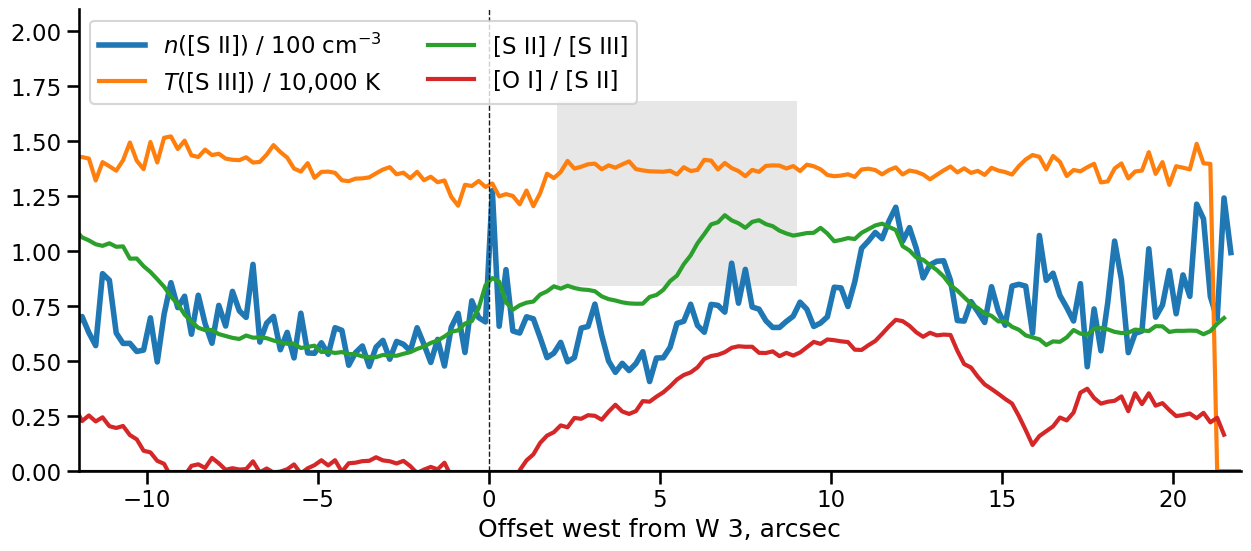

In [91]:
fig, ax = plt.subplots(figsize=(15, 6))
ix0 = 227.5
nx = len(sii_profile)
pos = (np.arange(nx) - ix0) * 0.2
pos2 = (np.arange(len(siii_profile)) - ix0) * 0.2

ax.plot(pos, 0.01 * n_sii_profile, label="$n$([S II]) / 100 cm$^{-3}$", lw=4)
ax.plot(pos2, 0.0001 * T_siii_profile, label="$T$([S III]) / 10,000 K", lw=3)
ax.plot(pos2, 1.0 * sii_profile[1:] / siii_profile, label="[S II] / [S III]", lw=3)
ax.plot(pos2, 4.0 * oi_profile / sii_profile[1:], label="[O I] / [S II]", lw=3)


ax.axhline(0, color="k")

ax.axvline(0, color="k", lw=1, ls="dashed")
ax.axvspan(2.0, 9.0, 0.4, 0.8, color="k", alpha=0.1, linewidth=0, zorder=-100)
ax.legend(ncol=2, loc="upper left")

ax.set(
    xlabel="Offset west from W 3, arcsec",
    xlim=[-12, 22],
    ylim=[0, 2.1],
)
sns.despine()
fig.savefig(figdir / "ngc346-bow-shock-sii-siii-ratio-ne-te.pdf")

In [94]:
imhei_c = Image(str(datadir / "ngc346-hei-5875-correct.fits"))
imhi_c = Image(str(datadir / "ngc346-hi-4861-correct.fits"))
imheii_c = Image(str(datadir / "ngc346-heii-4686-correct.fits"))
imcont2 = Image(str(datadir / "ngc346-cont-4686-mean.fits"))


In [95]:
m = imcont2.data > 500.0
for im in imhei_c, imheii_c, imhi_c:
    im.mask = im.mask | m

In [96]:
# yyslice = slice(164, 204) # original
yyslice = slice(160, 210)  # broader
# yyslice = slice(170, 200) # narrower
# yyslice = slice(180, 200) # top half ultra narrow
hei_c_profile = make_profile(imhei_c)
hi_c_profile = make_profile(imhi_c)
heii_c_profile = make_profile(imheii_c)

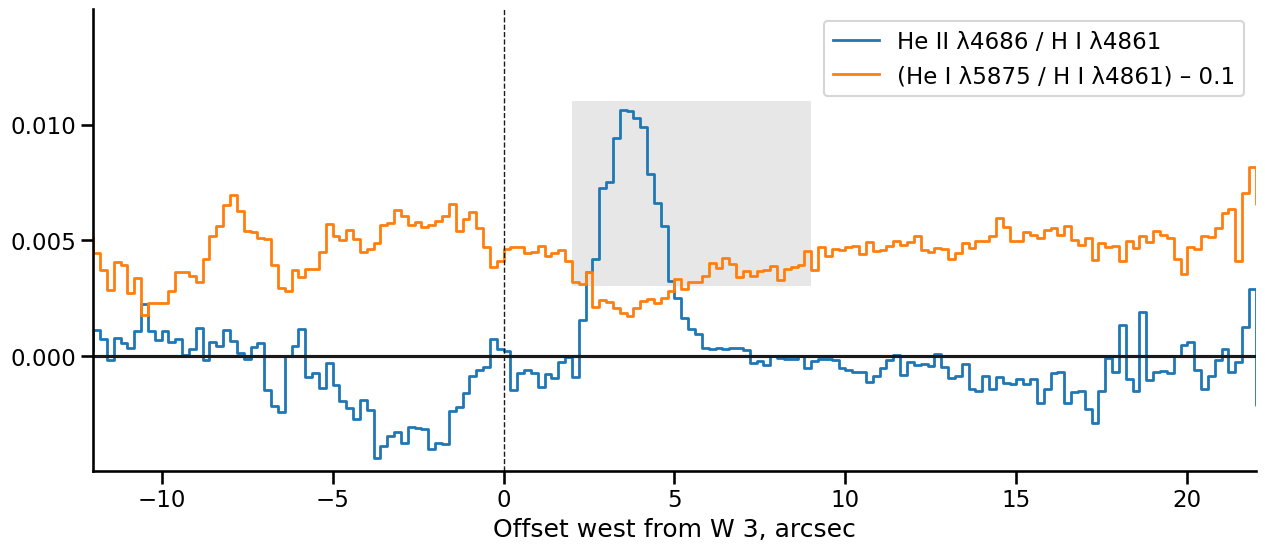

In [97]:
fig, ax = plt.subplots(figsize=(15, 6))
ix0 = 227.5
nx = len(hei_profile)
pos = (np.arange(nx) - ix0) * 0.2

ax.plot(
    pos,
    heii_c_profile / hi_c_profile,
    ds="steps-mid",
    label="He II λ4686 / H I λ4861",
    lw=2,
)
ax.plot(
    pos,
    hei_c_profile / hi_c_profile - 0.10,
    ds="steps-mid",
    label="(He I λ5875 / H I λ4861) – 0.1",
    lw=2,
)

ax.axhline(0, color="k")

ax.axvline(0, color="k", lw=1, ls="dashed")
ax.axvspan(2.0, 9.0, 0.4, 0.8, color="k", alpha=0.1, linewidth=0, zorder=-100)
ax.legend(ncol=1, loc="upper right")
ax.set_yticks([0.0, 0.005, 0.010])
ax.set(
    xlabel="Offset west from W 3, arcsec",
    xlim=[-12, 22],
    ylim=[-0.005, 0.015],
)
sns.despine()
fig.savefig(figdir / "ngc346-bow-shock-he-ratios.pdf")

In [98]:
im5518 = Image(str(datadir / "ngc346-cliii-5518-bin01-sum.fits"))
im5538 = Image(str(datadir / "ngc346-cliii-5538-bin01-sum.fits"))
imha = Image(str(datadir / "ngc346-hi-6563-bin01-sum.fits"))
imcont = Image(str(datadir / "ngc346-cont-4686-mean.fits"))

In [99]:
cl3 = pn.Atom("Cl", 3)
Rlo = cl3.getLowDensRatio(wave1=5518, wave2=5538)
Rhi = cl3.getHighDensRatio(wave1=5518, wave2=5538)
Rlo, Rhi

(1.5, 0.213477825334669)

In [100]:
m = imcont.data > 3e2
im5518.mask = im5518.mask | m
im5538.mask = im5538.mask | m
trim_edges(im5518, 20)
trim_edges(im5538, 20)
trim_edges(imcont, 20)

In [101]:
shift5538 = 15.0
shift5518 = 23.0
im5538.data += shift5538
im5518.data += shift5518

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


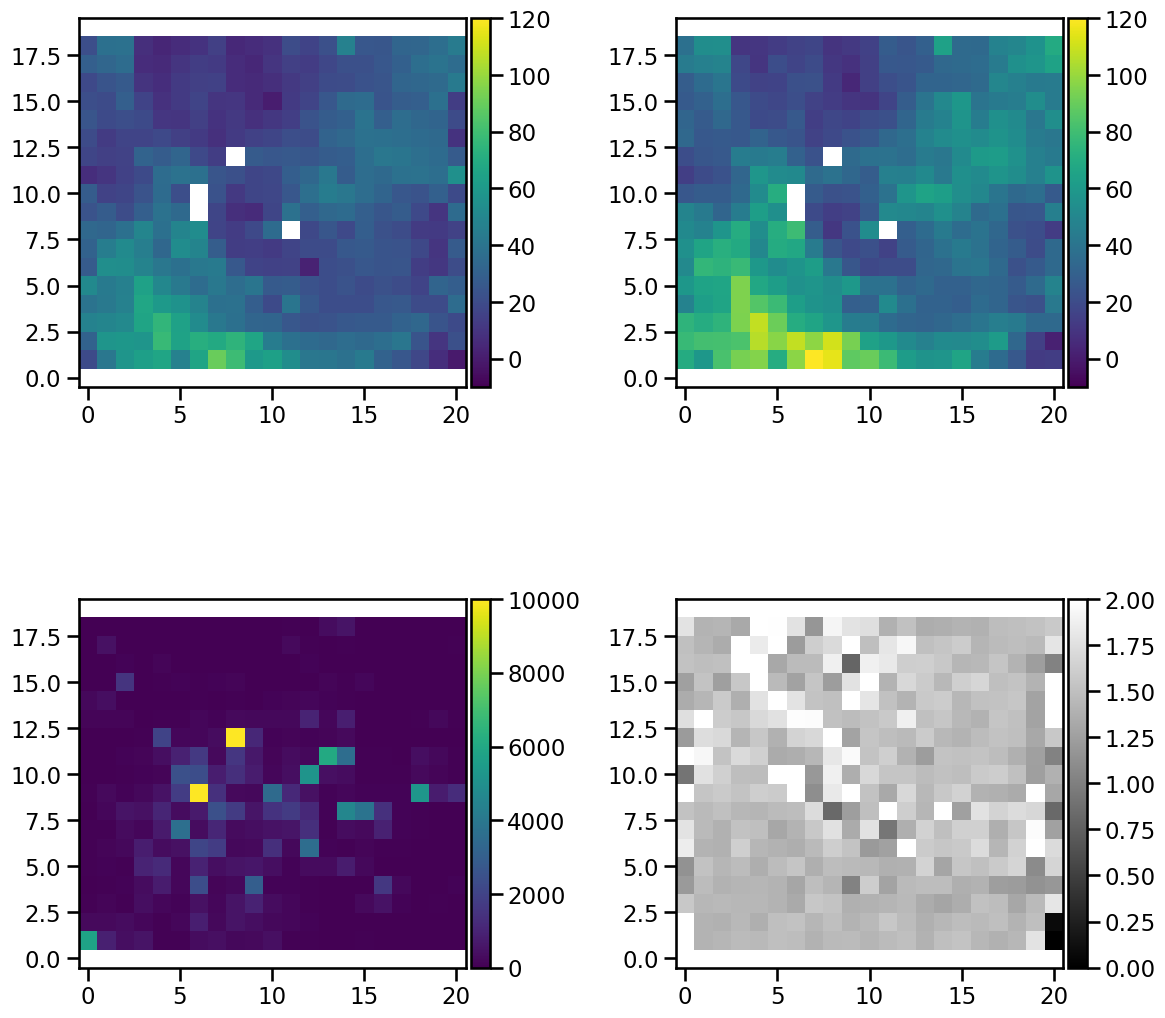

In [102]:
n = 16
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
im5538.rebin(n).plot(vmin=-10, vmax=120, ax=axes[0, 0], colorbar="v")
im5518.rebin(n).plot(vmin=-10, vmax=120, ax=axes[0, 1], colorbar="v")
imcont.rebin(n).plot(vmin=0, vmax=1e4, ax=axes[1, 0], colorbar="v")
(im5518.rebin(n) / im5538.rebin(n)).plot(
    ax=axes[1, 1],
    vmin=0.0,
    vmax=2.0,
    cmap="gray",
    colorbar="v",
)
fig.tight_layout()

Text(0.5, 0.98, 'Correlation between [Cl III] 5538 and 5518 brightness')

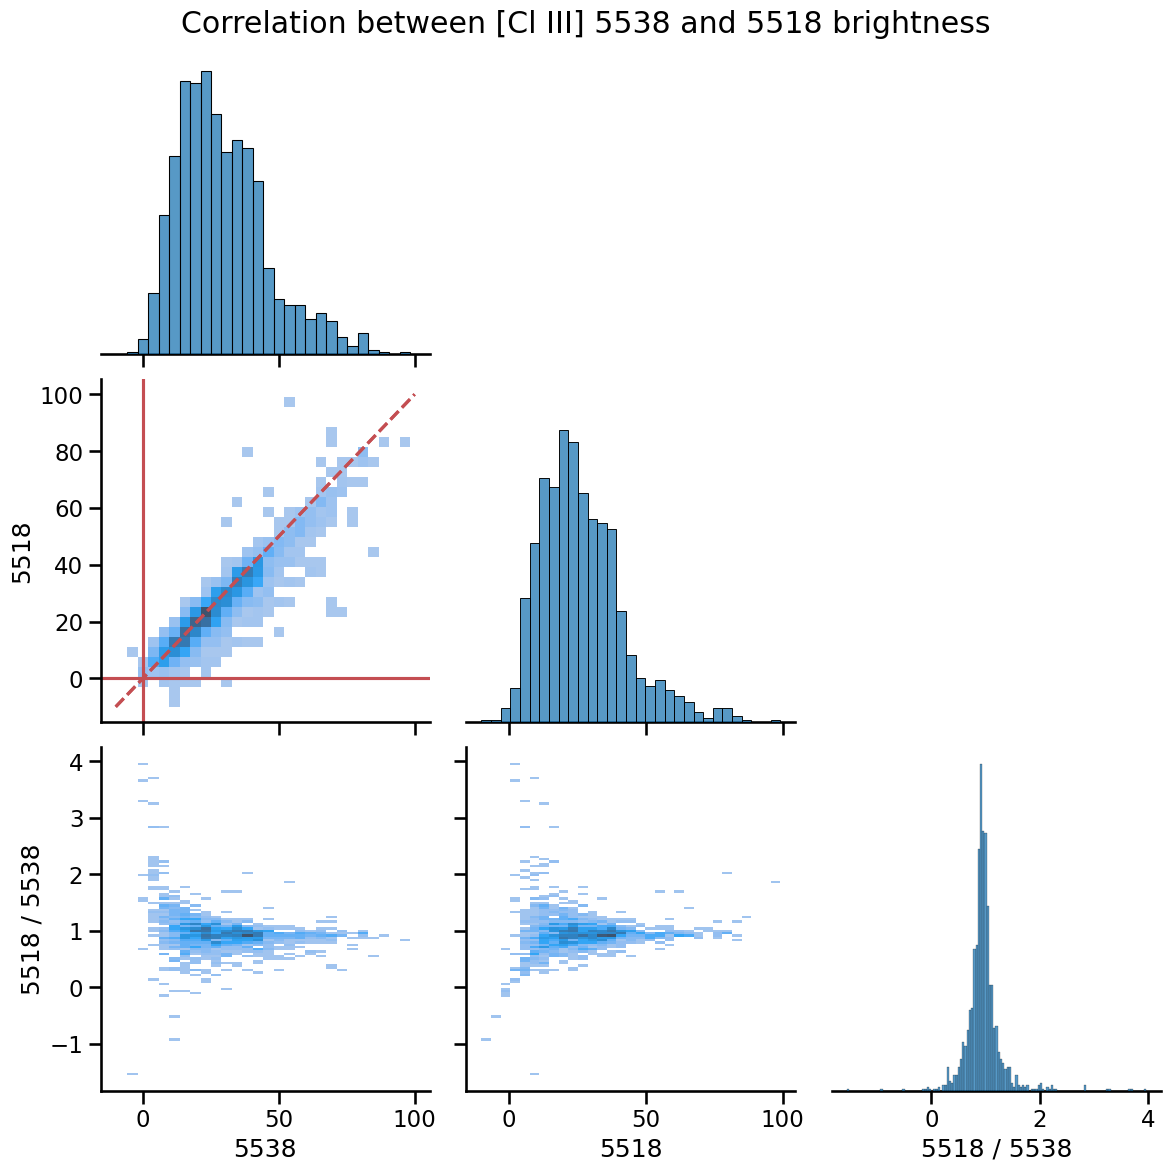

In [103]:
n = 8

imx = im5538.rebin(n)
imy = (im5518 / Rlo).rebin(n)

imin, imax = -10, 100
m = (imx.data < imax) & (imy.data < imax)
m = m & (imx.data > imin) & (imy.data > imin)
m = m & (imy.data / imx.data > -2) & (imy.data / imx.data < 4.0)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "5538": imx.data[m],
        "5518": imy.data[m],
        "5518 / 5538": imy.data[m] / imx.data[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([imin, imax], [imin, imax], "--", color="r")
g.axes[1, 0].plot([imin, imax], [imin, imax], "--", color="r")
g.fig.suptitle("Correlation between [Cl III] 5538 and 5518 brightness")

Text(0.5, 0.98, 'Correlation between [Cl III] 5538, 5518 sum and ratio')

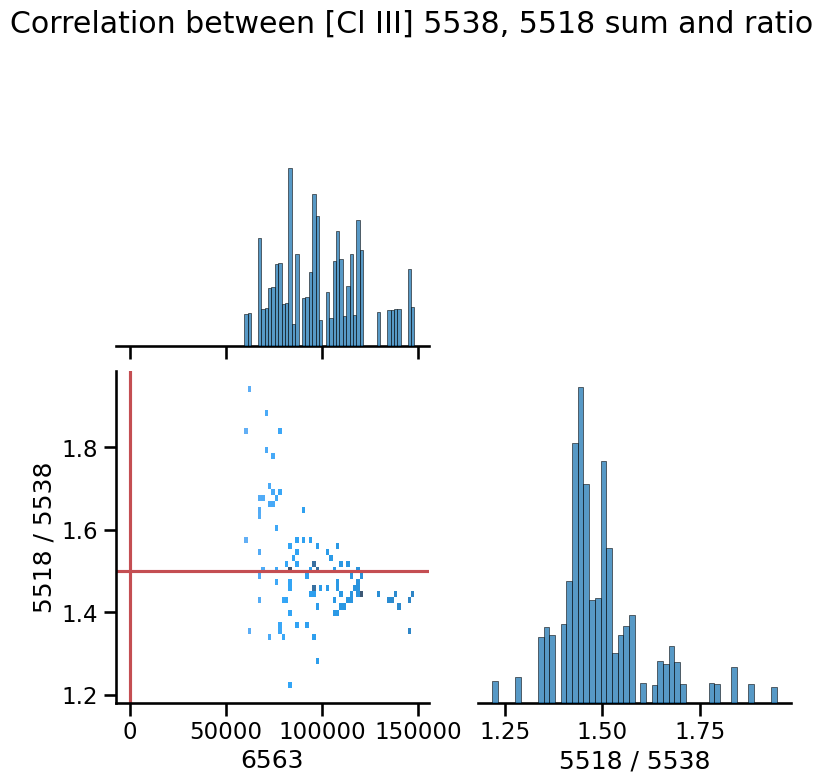

In [104]:
n = 32

imx = imha.rebin(n)
imy = im5518.rebin(n) / im5538.rebin(n)

imin, imax = -10, 100
m = (imy.data > 0.5) & (imy.data < 2.0)
m = m & (imx.data < 1.5e5)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6563": imx.data[m],
        "5518 / 5538": imy.data[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imx.data[m],
        bins=50,
    ),
    diag_kws=dict(
        weights=imx.data[m],
        bins=50,
    ),
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(1.5, color="r")
g.fig.suptitle("Correlation between [Cl III] 5538, 5518 sum and ratio")

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


Text(0.5, 0.98, 'Correlation between [Cl III] 5538 / 5518 ratio and Ha brightness')

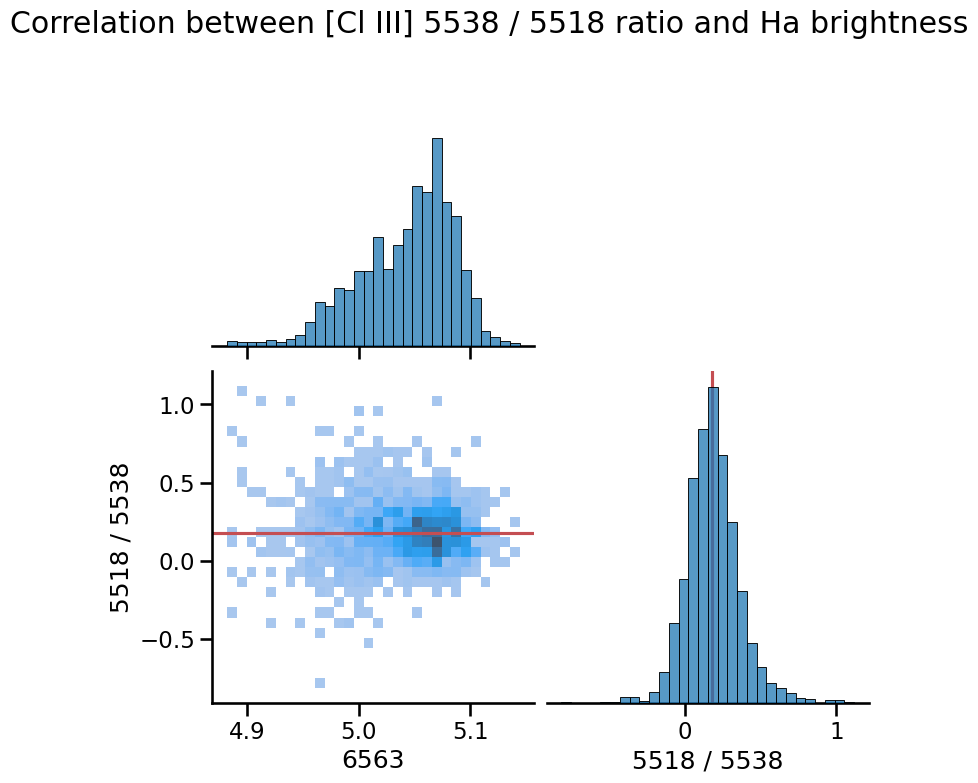

In [105]:
xslice, yslice = slice(230, 300), slice(144, 245)

n = 2

imx = imha[yslice, xslice].rebin(n)
imy = im5518[yslice, xslice].rebin(n) / im5538[yslice, xslice].rebin(n)

imin, imax = -10, 100
m = (imy.data > 0.15) & (imy.data < 15.0)
m = m & (imx.data < 1.5e5)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6563": np.log10(imx.data[m]),
        "5518 / 5538": np.log10(imy.data[m]),
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imx.data[m],
        bins=30,
    ),
    diag_kws=dict(
        weights=imx.data[m],
        bins=30,
    ),
)
g.axes[1, 0].axhline(np.log10(1.5), color="r")
g.axes[1, 1].axvline(np.log10(1.5), color="r")


g.fig.suptitle("Correlation between [Cl III] 5538 / 5518 ratio and Ha brightness")

In [106]:
m = ~im5518[yslice, xslice].mask
npix = m.sum()
y = im5518[yslice, xslice].data[m]
x = im5538[yslice, xslice].data[m]
w = imha[yslice, xslice].data[m]

# unweighted
ym = y.mean()
xm = x.mean()
R1 = ym / xm
dR1 = np.sqrt((y.var() / ym ** 2 + x.var() / xm ** 2) / (npix - 1))

# weighted
ymw = np.average(y, weights=w)
xmw = np.average(x, weights=w)
R2 = ymw / xmw
dR2 = np.sqrt(
    (
        np.average(((y - ymw) / ymw) ** 2, weights=w)
        + np.average(((x - ymw) / xmw) ** 2, weights=w)
    )
    / (npix - 1)
)
f"Unweighted R = {R1:.4f} +/- {dR1:.4f}; Weighted R = {R2:.4f} +/- {dR2:.4f}"

'Unweighted R = 1.4959 +/- 0.0090; Weighted R = 1.4937 +/- 0.0107'

In [107]:
cl3.getTemDen(1.44, tem=12000, wave1=5518, wave2=5538)

12.689610031679221

In [108]:
e5518 = cl3.getEmissivity(tem=12000, den=[1, 10, 100, 1000], wave=5518)
e5538 = cl3.getEmissivity(tem=12000, den=[1, 10, 100, 1000], wave=5538)
e5518 / e5538

array([1.44396914, 1.44119942, 1.41416716, 1.19711876])

In [109]:
e5518 = cl3.getEmissivity(tem=15000, den=[1, 10, 100, 1000], wave=5518)
e5538 = cl3.getEmissivity(tem=15000, den=[1, 10, 100, 1000], wave=5538)
e5518 / e5538

array([1.4285447 , 1.42601153, 1.40124273, 1.19934751])

In [110]:
e5518 = cl3.getEmissivity(tem=8000, den=[1, 10, 100, 1000], wave=5518)
e5538 = cl3.getEmissivity(tem=8000, den=[1, 10, 100, 1000], wave=5538)
e5518 / e5538

array([1.4658756 , 1.46262646, 1.43103423, 1.18496487])

Check the 2 sigma lower limit

In [111]:
cl3.getTemDen(R2 - 5 * dR2, tem=15000, wave1=5518, wave2=5538)

nan

In [112]:
cl3.getTemDen(R2 - 5 * dR2, tem=1000, wave1=5518, wave2=5538)

nan